In [1]:
ggVennDiagram::ggVennDiagram(list(A=c('a','b'), B=c('b','c','d')))

ERROR: Error in dyn.load(file, DLLpath = DLLpath, ...): unable to load shared object '/users/genomics/xoel/venvs/r_venn/lib/R/library/sf/libs/sf.so':
  libproj.so.15: cannot open shared object file: No such file or directory



> setwd("/users/genomics/xoel/codebases/co_new/results/")

> plotdir <- "Plots/"

> dir.create(plotdir, showWarnings = F)

> library(ggplot2)

> library(ggh4x)

> library(ggpubr)

> library(ggrepel)

> library(tidyr)

> library(dplyr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





> fig <- function(width, heigth) {
+     options(repr.plot.width = width, repr.plot.height = heigth)
+ }

> CellTypeAnnot <- c("vRG E", "vRG L", "tRG", "oRG E", 
+     "oRG L", "nIPC", "Neu E", "GluN3", "GluN1", "GluN2", "GluN7", 
+     "GluN5", "GluN4", " ..." ... [TRUNCATED] 

> CellTypeOrder <- c("RGC", "vRG", "vtRG", "oRG", "RG E", 
+     "RG L", "vRG E", "vRG L", "tRG", "oRG E", "oRG L", "Neural", 
+     "GluN", "nIPC", " ..." ... [TRUNCATED] 

> CellTypeLabels <- CellTypeOrder

> CellTypeColor <- setNames(c("#bec1d4", "#7d87b9", 
+     "#023fa5", "#d6bcc0", "#bb7784", "#8e063b", "#b5bbe3", "#8595e1", 
+     "#4a6fe3", "#e6afb ..." ... [TRUNCATED] 

> ctinfo <- data.frame(hex = CellTypeColor, Name = factor(names(CellTypeColor))) %>% 
+     mutate(`Common label` = Name)

> plot.celltype <- ggplot(data = ctinfo, mapping = aes(x = 0, 
+     y = Name, fill = `Common label`)) + geom_tile() + scale_fill_manual(values = Cell .... [TRUNCATED] 

> plot.celltype

> write.csv(ctinfo, file =

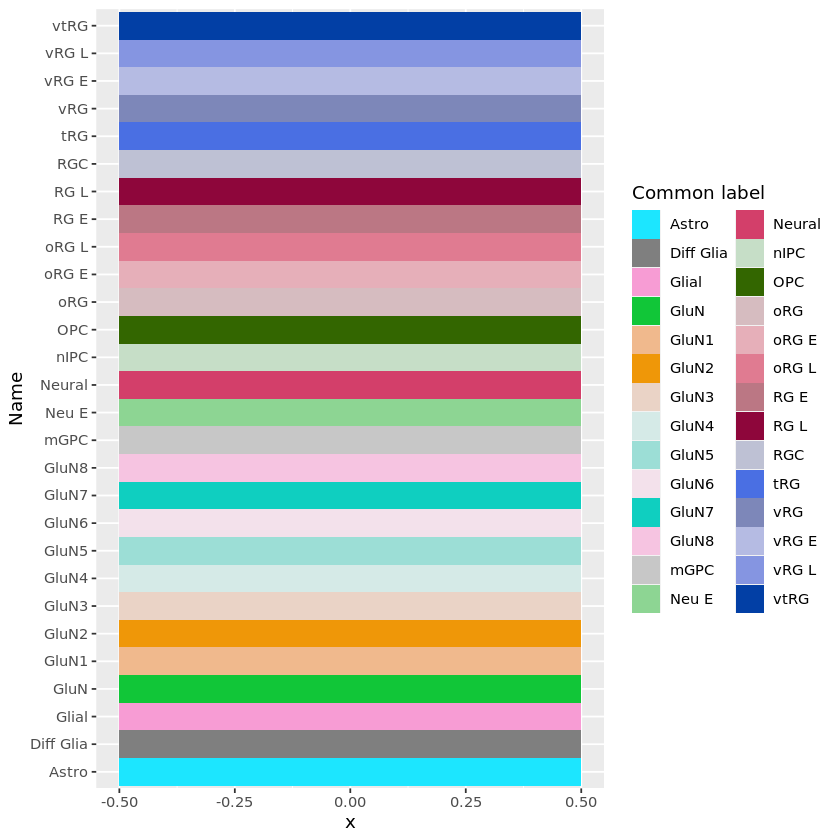

In [1]:
source('0_Rplots.R', echo=T)

In [2]:
pdir <- paste0(getwd(), '/Plots/NoackComparison/')
dir.create(pdir, showWarnings = F, recursive = T)
setwd(pdir)

### Load comparison data

In [3]:
ct.factors <- c('Progenitors', 'nIPC', 'Neural')

In [4]:
# Perturbation Summaries
pert_trevino <- readxl::read_excel('../../PerturbationSummaryNeurogenesis.xlsx')
pert_trevino$log2_ratio <- log2(pert_trevino$ratio)
pert_trevino$cell.type <- gsub('RGC', 'Progenitors', pert_trevino$cell.type)

# Summarise increase/decrease in each dataset
pert_trevino$HumanEf <- factor(ifelse(pert_trevino$log2_ratio > 0, 'Up', 'Down'),
                               levels=c('Up', 'Down'))


In [5]:
# Perturbation Summaries
pert_noack <- readxl::read_excel('../../PerturbationSummaryNoack.xlsx')
pert_noack$log2_ratio <- log2(pert_noack$ratio)
pert_noack$cell.type <- gsub('NSC', 'Progenitors', pert_noack$cell.type)
pert_noack$MouseEf <- factor(ifelse(pert_noack$log2_ratio > 0, 'Up', 'Down'),
                             levels=c('Up', 'Down'))


### Mouse to human orthologues

In [6]:
human_orthologues <- orthogene::convert_orthologs(unique(pert_noack$Gene),
                             input_species = "mouse",
                             output_species = "human",
                             non121_strategy = "drop_both_species")

Preparing gene_df.

character format detected.

Converting to data.frame

Extracting genes from input_gene.

160 genes extracted.

Converting mouse ==> human orthologs using: gprofiler

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: mmusculus

Retrieving all organisms available in gprofiler.

Using stored `gprofiler_orgs`.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: hsapiens

Checking for genes without orthologs in human.

Extracting genes from input_gene.

160 genes extracted.

Extracting genes from ortholog_gene.

160 genes extracted.

Checking for genes without 1:1 orthologs.

Filtering gene_df with gene_map

Setting ortholog_gene to rownames.


=========== REPORT SUMMARY ===========


Total genes dropped after convert_orthologs :
   0 / 160 (0%)

Total genes remaining after convert_orthologs

In [7]:
mouse_to_human <- structure(rownames(human_orthologues), names=human_orthologues$input_gene)

In [8]:
pert_noack$GeneMouse <- pert_noack$Gene

pert_noack$Gene <- mouse_to_human[pert_noack$GeneMouse]

### Plots

In [9]:
library(ggpmisc)
library(venn)

Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggh4x’:

    stat_centroid


The following object is masked from ‘package:ggplot2’:

    annotate




In [10]:
type.colors <- structure(
    c('forestgreen', 'tomato', 'yellow'), 
    names=c('Positive in both','Negative in both', 'Opposite effects'))

type.shapes <- structure(
    c('triangle filled','triangle down filled', 'circle filled'),
    names=c('Positive in both','Negative in both','Opposite effects'))

In [11]:
venn.colors <- c(H.Down='red', H.Up='gold', M.Up='green', M.Down='blue')

In [65]:
plot_scatter_1 <- function(df, midpoint=0){
    

    p <- ggplot(df,
           aes(x=log2_ratio.Noack, y=log2_ratio.sample)) + 


        # facet_nested(cols=vars(factor(cell.type, c('Progenitors', 'nIPC', 'Neural'))),
        #              scales='free', space='fixed', independent='all') + 
        facet_wrap(ncol = 3, facets = vars(factor(cell.type, ct.factors)),
                     scales='free') + 

        geom_hline(yintercept = midpoint) + geom_vline(xintercept = midpoint) + 
        stat_poly_line() +
        stat_poly_eq(use_label(c("eq", "R2"))) +
        # stat_summary(fun.data= mean_cl_normal) + 
        # geom_smooth(method='lm') +
        # stat_cor(label.y = 30)+ #this means at 35th unit in the y axis, the r squared and p value will be shown
        # stat_regline_equation(label.y = 35) +#this means at 30th unit regresion line equation will be shown

        geom_point(aes(fill=type, #fill=scaled.prod, 
                       shape=type,
                       size=scaled.dist
                      ), 
                   alpha=0.9) +
    
        geom_text_repel(aes(label=label),
                        force = 10,
                        min.segment.length = 0,
                        max.overlaps = 10
                 ) + 
    

        ggtitle('Log2 Ratio', subtitle=sample) +
        labs(x='Mouse (Noack)', y='Human (Trevino)') +

        # scale_fill_gradient2('Effect', 
        #                      low = 'tomato', mid= 'white', high = 'forestgreen',
        #                      # breaks=c(-1,1),
        #                      # labels=c('Opposite', 'Same'),
        #                      guide=guide_colorbar(title.position = 'top')) +
        # scale_fill_viridis_c(option='magma', direction = -1) +
    
        scale_fill_manual(values=type.colors) +
        scale_shape_manual(values=type.shapes) + 
        scale_size_continuous(range=c(1,4), 
                              limits=c(0,1)
                              # guide=guide_none()
                             ) +

        scale_x_continuous(expand = expansion(mult = 0.2)) +
        scale_y_continuous(expand = expansion(mult = 0.2)) +

        theme_pubr(legend = 'left',
                   # base_family = 'ArialTM'
                   ) + 

        theme(
              # text=element_text(family = 'ArialTM')
        )
 
    return(p)
}

In [66]:
fig(width = 16, heigth=6)
pdf(file = './test.pdf',
    # width = 1500, height = 500
    width = 15, height = 5,
    
    useDingbats = F
   )

all_contingencies <- list()

# For sample in trevino samples
for (sample in unique(pert_trevino$Sample)){

    message(sample)
    # Take dataframe of sample
    sample.df <- subset(pert_trevino, Sample == sample)
    
   
    # Merge dataframes
    comp.df <- merge(
        sample.df[,c('cell.type', 'Gene', 'log2_ratio', 'HumanEf')],
        pert_noack[,c('cell.type', 'Gene', 'log2_ratio', 'MouseEf')],
        by=c('cell.type', 'Gene'), all.x=T, all.y=T, suffixes=paste0('.', c('sample', 'Noack')))


    # Control for missing genes
    incomp.sum <- table(Noack=unique(comp.df$Gene) %in% pert_noack$Gene,
                        sample=unique(comp.df$Gene) %in% sample.df$Gene)
    print('Compatible observations (number of genes measured in both systems):')
    print(incomp.sum)
    comp.df <- comp.df[!apply(is.na(comp.df), 1, any),]

    # Control for infinite values of log2ratio
    inf.sum <- table(as.data.frame(t(!apply(comp.df[,c('log2_ratio.Noack', 'log2_ratio.sample')], 1, is.finite))))
    if ('TRUE' %in% unique(unlist(dimnames(inf.sum)))){
        print('Non-finite log2 ratios (-Inf -> all cells depleted)')
        print(inf.sum)
    }
    
    # Scale and annotate
    comp.df <- comp.df %>% group_by(cell.type) %>% mutate(
        
        scaled.sample=scales::rescale_mid(log2_ratio.sample,  from = range(log2_ratio.sample, finite=T),
                                          mid = 0, to = c(-1,1)),
        scaled.Noack=scales::rescale_mid(log2_ratio.Noack, from = range(log2_ratio.Noack, finite=T),
                                         mid = 0, to = c(-1,1)),
        
        prod=log2_ratio.Noack * log2_ratio.sample,
        dist=sqrt(log2_ratio.Noack**2 + log2_ratio.sample**2),

        type=ifelse(
            (prod > 0) & (log2_ratio.sample > 0),
            'Positive in both', ifelse(
            (prod > 0) & (log2_ratio.sample < 0),
            'Negative in both', 'Opposite effects'
            )),

        scaled.prod=scales::rescale_mid(prod, mid = 0, to = c(-1,1)),
        scaled.dist=scales::rescale(dist, to = c(0,1))

    ) %>% ungroup()
    
    # Decide which ones to label
    comp.df <- comp.df %>% group_by(cell.type, type) %>% mutate(
        label = ifelse(rank(x = desc(dist), na.last = T) <= 5, Gene, NA))

    
    # Get contingency table and compute fisher exact test
    contingencies <- do.call('rbind', lapply(ct.factors, function(ct){
        # Get dataframe of cell type
        # print(ct)
        ct.df <- subset(comp.df, cell.type == ct)
        
        # Get contingency table dividing mouse and human effects
        contingency.table <- table(data.frame(ct.df[,c('MouseEf', 'HumanEf')]))     
        print(contingency.table)
        
        # Compute fisher
        fish <- fisher.test(contingency.table, alternative = 'greater')
        fish <- data.frame(t(structure(
            unlist(fish),
            names=make.names(names(unlist(fish))))))
        
        # Long format of contingency
        cont <- reshape2::melt(contingency.table)
        cont <- data.frame(t(data.frame(
            row.names=paste0(colnames(cont)[1], '=', cont[,1],
                             '.', colnames(cont)[2], '=', cont[,2]), cont$value)), row.names=NULL)
        cont$Sample <- sample
        cont$cell.type <- ct
        
        # Append fisher results to table
        cont <- cbind(cont, fish )
        return(cont)
    }))    
    # Append to gather all samples
    all_contingencies[[sample]] <- contingencies
    
    
    # Similar approach to plot Venn diagrams
    venns <- lapply(ct.factors, function(ct){
        
        ct.df <- subset(comp.df, cell.type == ct)
        
        print
        # Split genes
        human.genes <- split(ct.df$Gene, ct.df$HumanEf)
        names(human.genes) <- paste('H', names(human.genes), sep='.')
        mouse.genes <- split(ct.df$Gene, ct.df$MouseEf)
        names(mouse.genes) <- paste('M', names(mouse.genes), sep='.')
        
        genes.venn.list <- c(human.genes, mouse.genes)[names(venn.colors)]
        print(ct)
        print(venn.colors)
        print(unname(venn.colors))
        print(genes.venn.list)
        print(sapply(genes.venn.list, length))
        
        # Rename for shorter
        names(genes.venn.list) %>% 
            gsub(pattern='.Down', replacement = '-', fixed=T) %>% 
            gsub(pattern='.Up', replacement = ' +', fixed=T) -> names(genes.venn.list)
        
        # Plot venn
        ggvenn::ggvenn(
            set_name_size = 6,
            set_name_color = unname(venn.colors),
            genes.venn.list,
            fill_color = unname(venn.colors),
        ) + ggtitle(ct)
        
    })

    # stop()
    # Scatter plot
    p <- plot_scatter_1(comp.df, midpoint=0)
    plot(p)
    
    # This will plot the venn diagrams
    venns <- gridExtra::grid.arrange(venns[[1]], venns[[2]], venns[[3]], top=sample, ncol=3)
    
}

# Merge all contingencies
all_contingencies <- do.call('rbind', all_contingencies)

# Polish results
numeric.fish.cols <- c('p.value','conf.int1','conf.int2','estimate.odds.ratio', 'null.value.odds.ratio')
all_contingencies[,numeric.fish.cols] <- apply(all_contingencies[,numeric.fish.cols], 2, as.numeric)
all_contingencies$significant <- all_contingencies$p.value < 0.05
# Sort table
all_contingencies <- all_contingencies %>% 
    mutate(cell.typeFct = factor(cell.type, ct.factors),
           data.name=NULL, method=NULL) %>% arrange(Sample, cell.typeFct)

# Plot table of contingencies
plot.new()
gridExtra::grid.table(all_contingencies,
                      theme = gridExtra::ttheme_default(
                        core = list(fg_params=list(cex = 0.5)),
                        colhead = list(fg_params=list(cex = 0.5)),
                        rowhead = list(fg_params=list(cex = 0.5))))

dev.off()



NeuralPCW16



[1] "Compatible observations (number of genes measured in both systems):"
       sample
Noack   FALSE TRUE
  FALSE     0   69
  TRUE     89   71
       HumanEf
MouseEf Up Down
   Up   35    6
   Down 16   14
       HumanEf
MouseEf Up Down
   Up   13    9
   Down 20   29
       HumanEf
MouseEf Up Down
   Up   19   23
   Down  7   22
[1] "Progenitors"
 H.Down    H.Up    M.Up  M.Down 
  "red"  "gold" "green"  "blue" 
[1] "red"   "gold"  "green" "blue" 
$H.Down
 [1] "ARX"    "CREB5"  "FOS"    "FOSB"   "GLI3"   "ID2"    "ID4"    "JUN"   
 [9] "JUNB"   "KLF6"   "MAF"    "NFE2L2" "NFIA"   "NR2E1"  "PAX6"   "PLAGL1"
[17] "SOX2"   "SOX6"   "SOX9"   "TCF7L2"

$H.Up
 [1] "ASCL1"   "ATF3"    "BACH2"   "BCL11A"  "BCL11B"  "BHLHE22" "CUX2"   
 [8] "DLX1"    "DLX5"    "E2F7"    "EGR1"    "EOMES"   "ERF"     "ETV5"   
[15] "HIVEP2"  "HIVEP3"  "ID3"     "INSM1"   "JUND"    "MAFB"    "MEF2C"  
[22] "MEIS2"   "NEUROD1" "NEUROD2" "NEUROD4" "NEUROD6" "NEUROG1" "NEUROG2"
[29] "NFAT5"   "NFATC2"  "NFATC4"  "

Warning message:
“Removed 168 rows containing missing values (`geom_text_repel()`).”
NeuralPCW20



[1] "Compatible observations (number of genes measured in both systems):"
       sample
Noack   FALSE TRUE
  FALSE     0   80
  TRUE     76   84
       HumanEf
MouseEf Up Down
   Up   46    3
   Down 18   17
       HumanEf
MouseEf Up Down
   Up    9   14
   Down 19   42
       HumanEf
MouseEf Up Down
   Up   37   15
   Down 16   16
[1] "Progenitors"
 H.Down    H.Up    M.Up  M.Down 
  "red"  "gold" "green"  "blue" 
[1] "red"   "gold"  "green" "blue" 
$H.Down
 [1] "ARX"    "ATF3"   "CREB5"  "ETV1"   "FOS"    "GLI3"   "ID2"    "ID4"   
 [9] "JUN"    "KLF6"   "NFE2L2" "NPAS3"  "PAX6"   "POU3F4" "SOX3"   "SOX6"  
[17] "SOX9"   "TCF7L1" "TFAP2C" "ZIC5"  

$H.Up
 [1] "ARID5B"  "ASCL1"   "BACH2"   "BCL11A"  "BCL11B"  "BHLHE22" "CUX2"   
 [8] "DLX1"    "DLX2"    "DLX5"    "E2F7"    "E2F8"    "EGR1"    "EGR2"   
[15] "EGR3"    "EOMES"   "FOSB"    "FOXP2"   "HIVEP3"  "ID1"     "ID3"    
[22] "INSM1"   "JUNB"    "JUND"    "KLF10"   "KLF4"    "KLF9"    "LHX1"   
[29] "MAF"     "MAFB"    "MEF2C"   "

Warning message:
“Removed 207 rows containing missing values (`geom_text_repel()`).”
NeuralPCW21



[1] "Compatible observations (number of genes measured in both systems):"
       sample
Noack   FALSE TRUE
  FALSE     0   77
  TRUE     87   73
       HumanEf
MouseEf Up Down
   Up   29   10
   Down 13   21
       HumanEf
MouseEf Up Down
   Up    5   14
   Down 14   40
       HumanEf
MouseEf Up Down
   Up   24   17
   Down 16   16
[1] "Progenitors"
 H.Down    H.Up    M.Up  M.Down 
  "red"  "gold" "green"  "blue" 
[1] "red"   "gold"  "green" "blue" 
$H.Down
 [1] "ARX"    "ATF3"   "BACH2"  "CREB5"  "CUX2"   "ETV1"   "FOS"    "FOSB"  
 [9] "GLI3"   "HIVEP3" "ID2"    "ID4"    "JUN"    "JUNB"   "KLF4"   "KLF6"  
[17] "MAF"    "MEF2C"  "MYBL2"  "MYC"    "NFATC2" "NPAS3"  "NR4A2"  "NR4A3" 
[25] "PAX6"   "SOX21"  "SOX3"   "SOX6"   "SOX9"   "TFAP2C" "YBX1"  

$H.Up
 [1] "ARID5B"  "ASCL1"   "BCL11A"  "BCL11B"  "BHLHE22" "DLX2"    "E2F1"   
 [8] "E2F2"    "EGR1"    "EGR2"    "EOMES"   "ID1"     "ID3"     "INSM1"  
[15] "JUND"    "KLF10"   "MAFB"    "MEIS2"   "NEUROD1" "NEUROD2" "NEUROD4"
[22] "N

Warning message:
“Removed 174 rows containing missing values (`geom_text_repel()`).”
NeuralPCW24



[1] "Compatible observations (number of genes measured in both systems):"
       sample
Noack   FALSE TRUE
  FALSE     0   86
  TRUE     73   87
       HumanEf
MouseEf Up Down
   Up   46    5
   Down 13   23
       HumanEf
MouseEf Up Down
   Up    6   15
   Down 12   54
       HumanEf
MouseEf Up Down
   Up   38   16
   Down  9   24
[1] "Progenitors"
 H.Down    H.Up    M.Up  M.Down 
  "red"  "gold" "green"  "blue" 
[1] "red"   "gold"  "green" "blue" 
$H.Down
 [1] "ARX"    "ATF3"   "CREB5"  "CUX1"   "ETV1"   "FOSB"   "GLI3"   "ID2"   
 [9] "ID4"    "JUN"    "JUNB"   "KLF6"   "MAF"    "NFE2L2" "NPAS3"  "NR2E1" 
[17] "NR4A2"  "PAX6"   "POU3F4" "RFX4"   "SOX2"   "SOX3"   "SOX6"   "SOX9"  
[25] "TFAP2C" "TGIF1"  "ZIC1"   "ZIC5"  

$H.Up
 [1] "ARID5B"  "ASCL1"   "BATF3"   "BCL11A"  "BCL11B"  "BHLHE22" "CUX2"   
 [8] "DLX1"    "DLX2"    "DLX5"    "DMRTA1"  "EBF1"    "EGR1"    "EGR2"   
[15] "EGR3"    "EOMES"   "FOS"     "FOXP2"   "FOXP4"   "ID1"     "ID3"    
[22] "INSM1"   "JUND"    "LHX1"   

Warning message:
“Removed 216 rows containing missing values (`geom_text_repel()`).”


png 
  2

## Plots 2

In [67]:
# First scatter plot, all samples in one plot, one per row. No need to show IPC
pert_human <- subset(pert_trevino, (Sample != 'NeuralPCW16') & (cell.type !='nIPC') )
# Merge dataframes
comp.df <- merge(
    pert_human[,c('cell.type', 'Gene', 'log2_ratio', 'Sample', 'HumanEf')],
    pert_noack[,c('cell.type', 'Gene', 'log2_ratio', 'MouseEf')],
    by=c('cell.type', 'Gene'), all.x=F, all.y=F, suffixes=c('.Human', '.Noack'))




# Scale and annotate
comp.df <- comp.df %>% group_by(Sample, cell.type) %>% mutate(

    scaled.Human=scales::rescale_mid(log2_ratio.Human,  from = range(log2_ratio.Human, finite=T),
                                      mid = 0, to = c(-1,1)),
    scaled.Noack=scales::rescale_mid(log2_ratio.Noack, from = range(log2_ratio.Noack, finite=T),
                                     mid = 0, to = c(-1,1)),

    prod=log2_ratio.Noack * log2_ratio.Human,
    dist=sqrt(log2_ratio.Noack**2 + log2_ratio.Human**2),

    type=ifelse(
        (prod > 0) & (log2_ratio.Human > 0),
        'Positive in both', ifelse(
        (prod > 0) & (log2_ratio.Human < 0),
        'Negative in both', 'Opposite effects'
        )),

    scaled.prod=scales::rescale_mid(prod, mid = 0, to = c(-1,1)),
    scaled.dist=scales::rescale(dist, to = c(0,1))

) %>% ungroup()

# Decide which ones to label
comp.df <- comp.df %>% group_by(Sample, cell.type, type) %>% mutate(
    label = ifelse(rank(x = desc(dist), na.last = T) <= 5, Gene, NA))

In [68]:
# Get contingency table and compute fisher exact test
contingencies2 <- do.call('rbind', lapply(unique(paste(comp.df$Sample, comp.df$cell.type, sep='|')), function(samct){

    # Get dataframe of cell type
    samctinfo <- strsplit(x = samct, split='|', fixed=T)[[1]] 
    samctinfo[1] -> sam
    samctinfo[2] -> ct
    
    ct.df <- subset(comp.df, (cell.type == ct) & (Sample == sam))

    # Get contingency table dividing mouse and human effects
    contingency.table <- table(data.frame(ct.df[,c('MouseEf', 'HumanEf')]))     
    # print(contingency.table)

    # Compute fisher
    fish <- fisher.test(contingency.table, alternative = 'greater')
    fish <- data.frame(t(structure(
        unlist(fish),
        names=make.names(names(unlist(fish))))))

    # Long format of contingency
    cont <- reshape2::melt(contingency.table)
    cont <- data.frame(t(data.frame(
        row.names=paste0(colnames(cont)[1], '=', cont[,1],
                         '.', colnames(cont)[2], '=', cont[,2]), cont$value)), row.names=NULL)
    cont$Sample <- sam
    cont$cell.type <- ct

    # Append fisher results to table
    cont <- cbind(cont, fish )
    return(cont)
}))    
numeric.fish.cols <- c('p.value','conf.int1','conf.int2','estimate.odds.ratio', 'null.value.odds.ratio')

contingencies2[,numeric.fish.cols] <- apply(contingencies2[,numeric.fish.cols], 2, as.numeric)
contingencies2$significant <- contingencies2$p.value < 0.05
# Sort table
contingencies2 <- contingencies2 %>% 
    mutate(cell.typeFct = factor(cell.type, ct.factors),
           data.name=NULL, method=NULL) %>% arrange(Sample, cell.typeFct)

contingencies2


MouseEf.Up.HumanEf.Up,MouseEf.Down.HumanEf.Up,MouseEf.Up.HumanEf.Down,MouseEf.Down.HumanEf.Down,Sample,cell.type,p.value,conf.int1,conf.int2,estimate.odds.ratio,null.value.odds.ratio,alternative,significant,cell.typeFct
<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<fct>
46,18,3,17,NeuralPCW20,Progenitors,8.302768e-06,4.1210607,Inf,13.960282,1,greater,TRUE,Progenitors
37,16,15,16,NeuralPCW20,Neural,4.328851e-02,1.0319345,Inf,2.438876,1,greater,TRUE,Neural
29,13,10,21,NeuralPCW21,Progenitors,1.876281e-03,1.8086762,Inf,4.576463,1,greater,TRUE,Progenitors
24,16,17,16,NeuralPCW21,Neural,3.119320e-01,0.5835202,Inf,1.405037,1,greater,FALSE,Neural
46,13,5,23,NeuralPCW24,Progenitors,1.154250e-07,5.4664153,Inf,15.606102,1,greater,TRUE,Progenitors
38,9,16,24,NeuralPCW24,Neural,9.499809e-05,2.5410847,Inf,6.181935,1,greater,TRUE,Neural


In [69]:
sub("(\\..*?)\\.", "\\1\\\n", colnames(contingencies2)) -> colnames(contingencies2)

Warning message:
“Removed 398 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


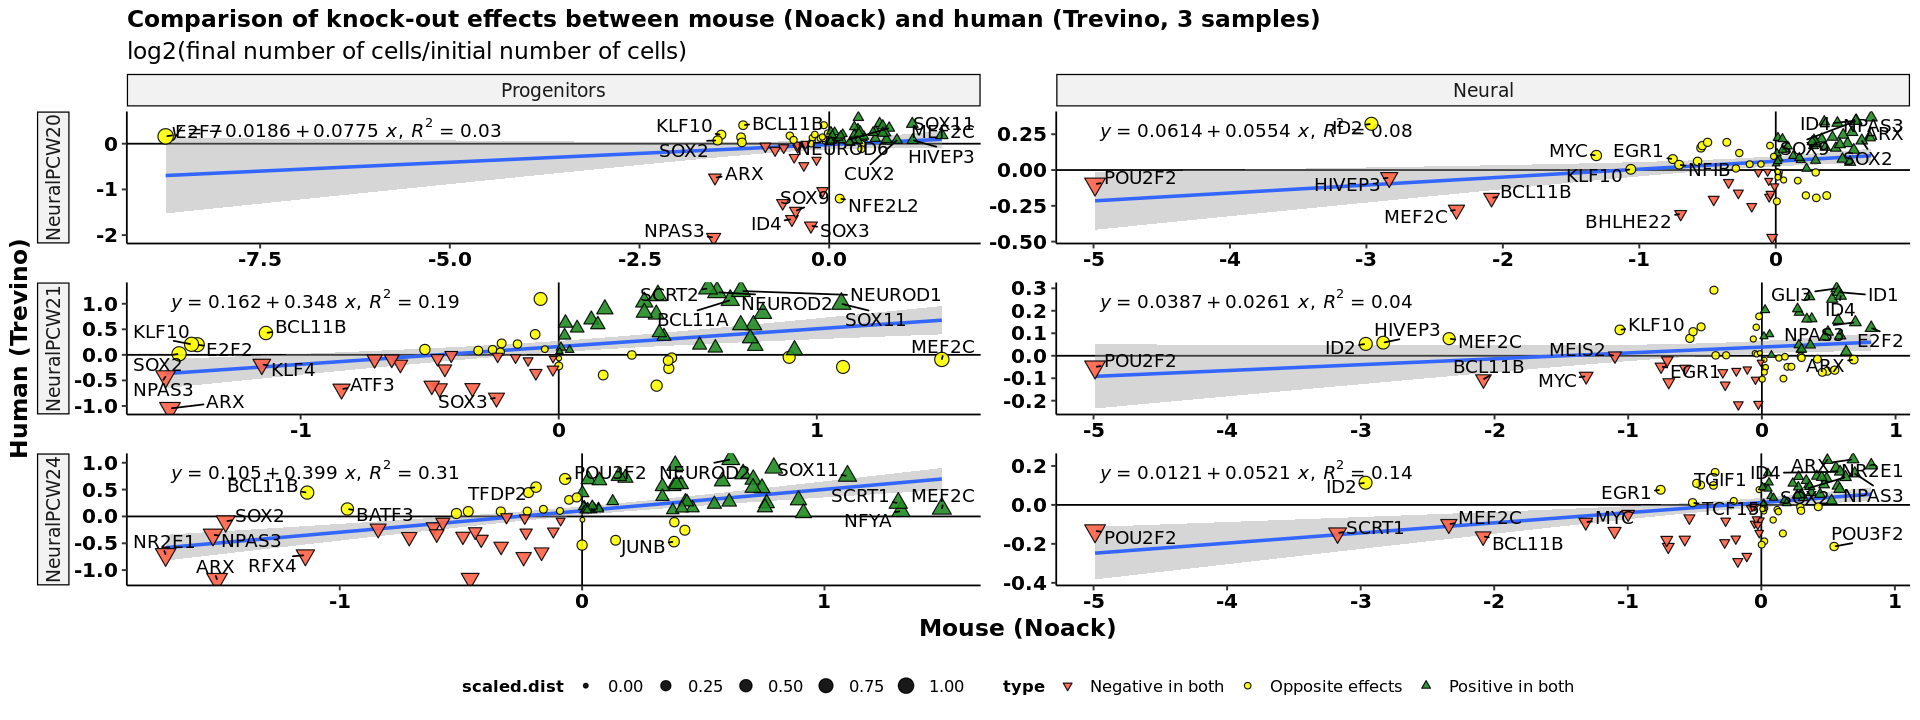

In [70]:
p2 <- ggplot(comp.df,
       aes(x=log2_ratio.Noack, y=log2_ratio.Human)) + 

    facet_grid2(independent='all', rows=vars(Sample), 
               cols = vars(factor(cell.type, ct.factors)),
               scales='free', switch='y') + 

    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + 
    stat_poly_line() +
    stat_poly_eq(use_label(c("eq", "R2"))) +

    geom_point(aes(fill=type, 
                   shape=type,
                   size=scaled.dist
                  ), 
               alpha=0.9) +

    geom_text_repel(aes(label=label),
                    force = 10,
                    min.segment.length = 0,
                    max.overlaps = 10
             ) + 


    ggtitle('Comparison of knock-out effects between mouse (Noack) and human (Trevino, 3 samples)', 
            subtitle='log2(final number of cells/initial number of cells)') +
    labs(x='Mouse (Noack)', y='Human (Trevino)') +

    scale_fill_manual(values=type.colors) +
    scale_shape_manual(values=type.shapes) + 
    scale_size_continuous(range=c(1,4), 
                          limits=c(0,1)
                          # guide=guide_none()
                         ) +

    theme_pubr(legend = 'bottom',
               # base_family = 'ArialTM'
               ) + labs_pubr() +

    theme(strip.placement = 'outside',
          # text=element_text(family = 'ArialTM')
    )


p2

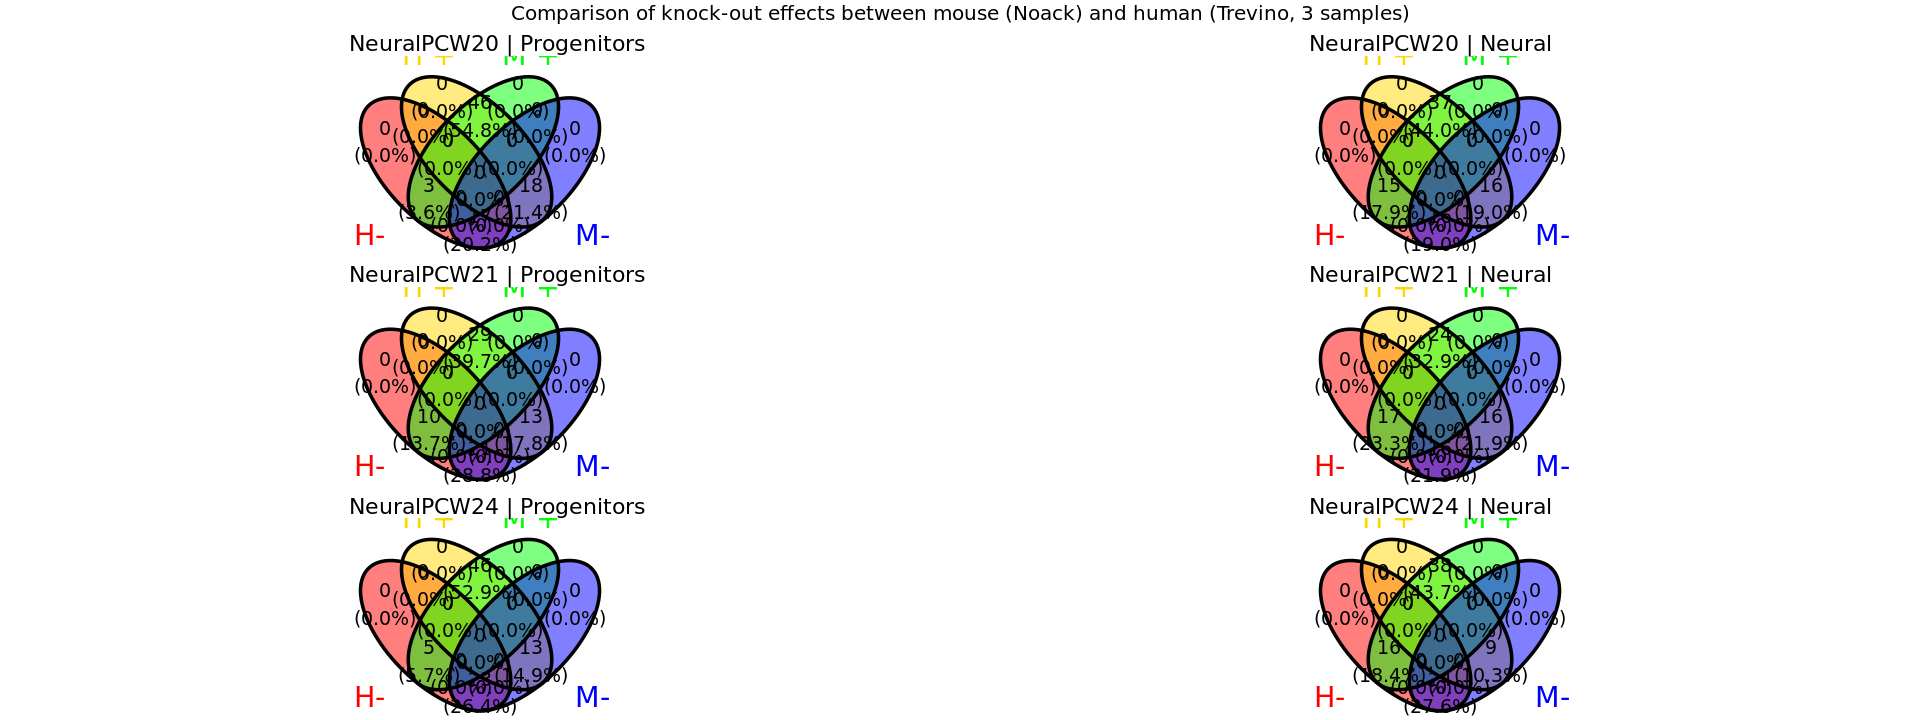

In [71]:
# Similar approach to plot Venn diagrams
venns2 <- lapply(sort(unique(paste(comp.df$Sample, comp.df$cell.type, sep='|'))), function(samct){

    # Get dataframe of cell type
    samctinfo <- strsplit(x = samct, split='|', fixed=T)[[1]] 
    samctinfo[1] -> sam
    samctinfo[2] -> ct
    
    ct.df <- subset(comp.df, (cell.type == ct) & (Sample == sam))

    # Split genes
    human.genes <- split(ct.df$Gene, ct.df$HumanEf)
    names(human.genes) <- paste('H', names(human.genes), sep='.')
    mouse.genes <- split(ct.df$Gene, ct.df$MouseEf)
    names(mouse.genes) <- paste('M', names(mouse.genes), sep='.')

    genes.venn.list <- c(human.genes, mouse.genes)[names(venn.colors)]

    # Rename for shorter
    names(genes.venn.list) %>% 
        gsub(pattern='.Down', replacement = '-', fixed=T) %>% 
        gsub(pattern='.Up', replacement = ' +', fixed=T) -> names(genes.venn.list)

    # Plot venn
    ggvenn::ggvenn(
        set_name_color = unname(venn.colors),
        set_name_size = 6,
        genes.venn.list,
        fill_color = unname(venn.colors),
    ) + ggtitle(paste(sam, '|', ct))

})


# This will plot the venn diagrams
venns_p2 <- gridExtra::grid.arrange(venns2[[2]], venns2[[1]],
                                    venns2[[4]], venns2[[3]],
                                    venns2[[6]], venns2[[5]],
                                    ncol=2, top='Comparison of knock-out effects between mouse (Noack) and human (Trevino, 3 samples)')


## Plots 3

In [72]:
compare_samples <- function(sample_1, sample_2){
    
    # Get dataframes
    df1 <- subset(pert_trevino, (Sample == sample_1) & (cell.type!='nIPC'))
    df2 <- subset(pert_trevino, (Sample == sample_2) & (cell.type!='nIPC'))
    
    # Merge them
    comp.df <- merge(
        df1[,c('cell.type', 'Gene', 'log2_ratio', 'Sample', 'HumanEf')],
        df2[,c('cell.type', 'Gene', 'log2_ratio', 'Sample', 'HumanEf')],
        by=c('cell.type', 'Gene'), all.x=F, all.y=F, suffixes=c('.sample1', '.sample2'))
    
    comp.df$comparison <- paste(sample_1, sample_2, sep='.vs.')
    
    return(comp.df)
}

# Second plot, same, but comparing human samples among them
do.call('rbind', lapply(
    list(c('NeuralPCW20', 'NeuralPCW21'),
         c('NeuralPCW21', 'NeuralPCW24'),
         c('NeuralPCW20', 'NeuralPCW24')), 
    function(comp){
        print(comp)
        comp.df <- compare_samples(comp[1], comp[2])
        comp.df
})) -> comp.df

# Scale and annotate
comp.df <- comp.df %>% group_by(comparison, cell.type) %>% mutate(

    scaled.sample1=scales::rescale_mid(log2_ratio.sample1,  from = range(log2_ratio.sample1, finite=T),
                                      mid = 0, to = c(-1,1)),
    scaled.sample2=scales::rescale_mid(log2_ratio.sample2, from = range(log2_ratio.sample2, finite=T),
                                     mid = 0, to = c(-1,1)),

    prod=log2_ratio.sample2 * log2_ratio.sample1,
    dist=sqrt(log2_ratio.sample2**2 + log2_ratio.sample1**2),

    type=ifelse(
        (prod > 0) & (log2_ratio.sample1 > 0),
        'Positive in both', ifelse(
        (prod > 0) & (log2_ratio.sample1 < 0),
        'Negative in both', 'Opposite effects'
        )),

    scaled.prod=scales::rescale_mid(prod, mid = 0, to = c(-1,1)),
    scaled.dist=scales::rescale(dist, to = c(0,1))

) %>% ungroup()

# Decide which ones to label
comp.df <- comp.df %>% group_by(comparison, cell.type, type) %>% mutate(
    label = ifelse(rank(x = desc(dist), na.last = T) <= 5, Gene, NA))

[1] "NeuralPCW20" "NeuralPCW21"
[1] "NeuralPCW21" "NeuralPCW24"
[1] "NeuralPCW20" "NeuralPCW24"


In [73]:
# Get contingency table and compute fisher exact test
contingencies3 <- do.call('rbind', lapply(unique(paste(comp.df$comparison, comp.df$cell.type, sep='|')), function(comct){

    # Get dataframe of cell type
    samctinfo <- strsplit(x = comct, split='|', fixed=T)[[1]] 
    samctinfo[1] -> com
    samctinfo[2] -> ct
    
    ct.df <- subset(comp.df, (cell.type == ct) & (comparison == com)) %>% mutate(Ef_sample1 = HumanEf.sample1, Ef_sample2 = HumanEf.sample2)

    # Get contingency table dividing mouse and human effects
    contingency.table <- table(data.frame(ct.df[,c('Ef_sample1', 'Ef_sample2')]))     
    # print(contingency.table)

    # Compute fisher
    fish <- fisher.test(contingency.table, alternative = 'greater')
    fish <- data.frame(t(structure(
        unlist(fish),
        names=make.names(names(unlist(fish))))))

    # Long format of contingency
    cont <- reshape2::melt(contingency.table)
    cont <- data.frame(t(data.frame(
        row.names=paste0(colnames(cont)[1], '=', cont[,1],
                         '.', colnames(cont)[2], '=', cont[,2]), cont$value)), row.names=NULL)
    cont$comparison <- com
    cont$cell.type <- ct
    cont$sample1 <- unique(ct.df$Sample.sample1)
    cont$sample2 <- unique(ct.df$Sample.sample2)

    # Append fisher results to table
    cont <- cbind(cont, fish )
    return(cont)
}))    
numeric.fish.cols <- c('p.value','conf.int1','conf.int2','estimate.odds.ratio', 'null.value.odds.ratio')

contingencies3[,numeric.fish.cols] <- apply(contingencies3[,numeric.fish.cols], 2, as.numeric)
contingencies3$significant <- contingencies3$p.value < 0.05
# Sort table
contingencies3 <- contingencies3 %>% 
    mutate(cell.typeFct = factor(cell.type, ct.factors),
           data.name=NULL, method=NULL) %>% arrange(sample1, sample2, cell.typeFct)

contingencies3


Ef_sample1.Up.Ef_sample2.Up,Ef_sample1.Down.Ef_sample2.Up,Ef_sample1.Up.Ef_sample2.Down,Ef_sample1.Down.Ef_sample2.Down,comparison,cell.type,sample1,sample2,p.value,conf.int1,conf.int2,estimate.odds.ratio,null.value.odds.ratio,alternative,significant,cell.typeFct
<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<fct>
50,2,22,26,NeuralPCW20.vs.NeuralPCW21,Progenitors,NeuralPCW20,NeuralPCW21,7.499871e-09,7.466614,Inf,28.512630,1,greater,TRUE,Progenitors
36,16,24,24,NeuralPCW20.vs.NeuralPCW21,Neural,NeuralPCW20,NeuralPCW21,3.927038e-02,1.047344,Inf,2.231334,1,greater,TRUE,Neural
57,3,15,30,NeuralPCW20.vs.NeuralPCW24,Progenitors,NeuralPCW20,NeuralPCW24,5.950077e-12,11.158840,Inf,36.227311,1,greater,TRUE,Progenitors
45,15,19,26,NeuralPCW20.vs.NeuralPCW24,Neural,NeuralPCW20,NeuralPCW24,6.523910e-04,1.880342,Inf,4.045168,1,greater,TRUE,Neural
51,10,5,33,NeuralPCW21.vs.NeuralPCW24,Progenitors,NeuralPCW21,NeuralPCW24,2.143424e-12,11.115958,Inf,31.848012,1,greater,TRUE,Progenitors
40,16,11,32,NeuralPCW21.vs.NeuralPCW24,Neural,NeuralPCW21,NeuralPCW24,5.659355e-06,3.118874,Inf,7.105299,1,greater,TRUE,Neural


In [82]:
gsub(contingencies3$comparison, pattern = '.vs.', replacement = '\n', fixed=T) -> contingencies3$comparison

In [74]:
sub("(\\..*?)\\.", "\\1\\\n", colnames(contingencies3)) -> colnames(contingencies3)

Warning message:
“Removed 518 rows containing missing values (`geom_text_repel()`).”


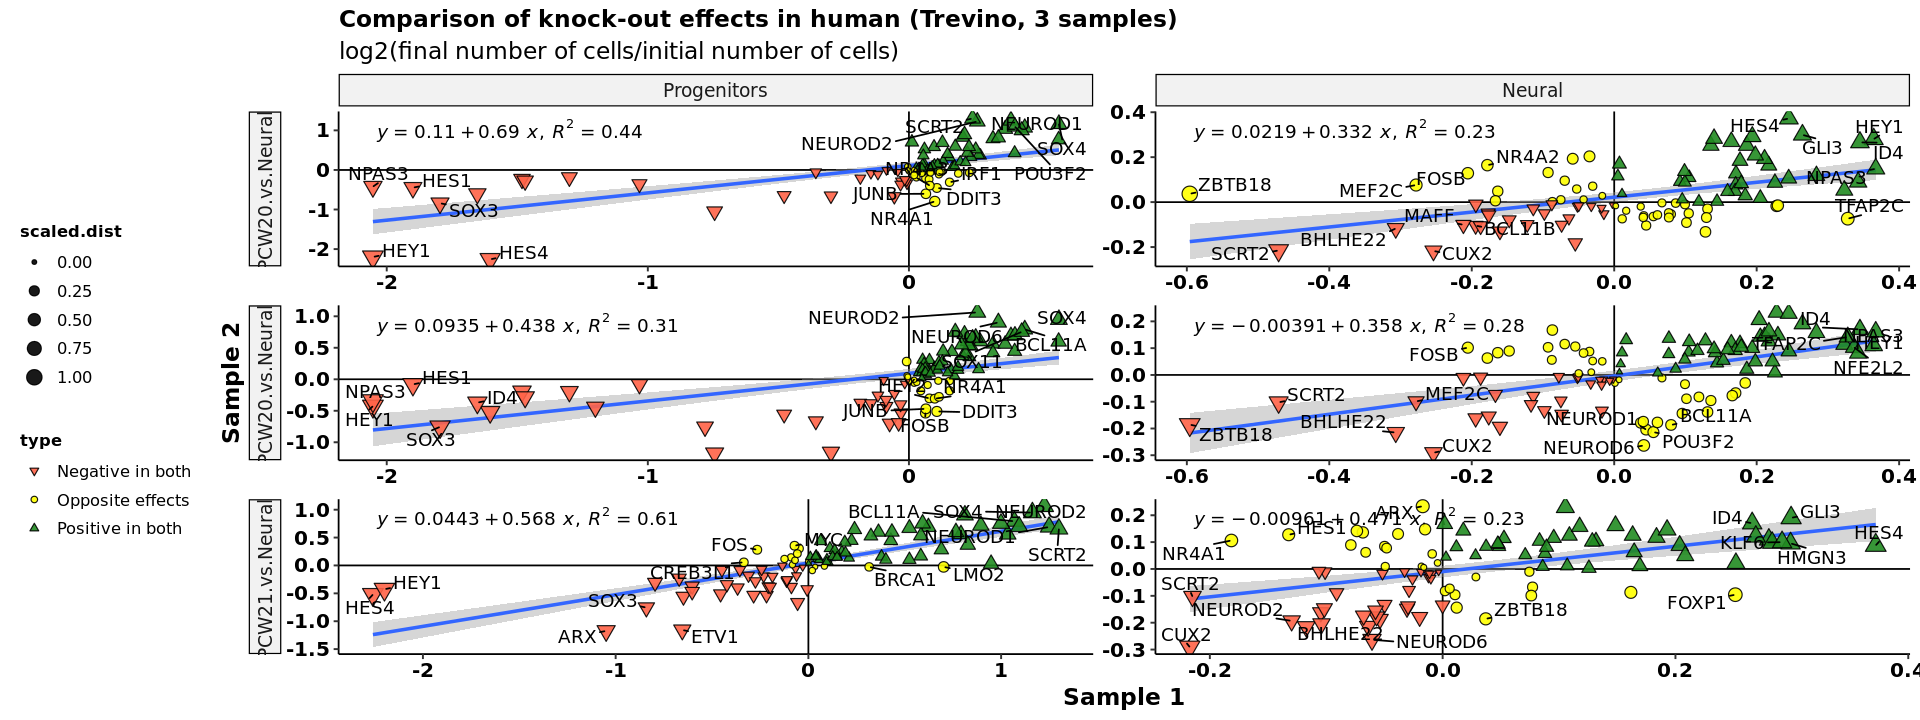

In [75]:
p3 <- ggplot(comp.df,
       aes(x=log2_ratio.sample1, y=log2_ratio.sample2)) + 

    facet_grid2(independent='all', rows=vars(comparison), 
               cols = vars(factor(cell.type, ct.factors)),
               scales='free', switch='y') + 

    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + 
    stat_poly_line() +
    stat_poly_eq(use_label(c("eq", "R2"))) +

    geom_point(aes(fill=type, 
                   shape=type,
                   size=scaled.dist
                  ), 
               alpha=0.9) +

    geom_text_repel(aes(label=label),
                    force = 10,
                    min.segment.length = 0,
                    max.overlaps = 10
             ) + 


    ggtitle('Comparison of knock-out effects in human (Trevino, 3 samples)', 
            subtitle='log2(final number of cells/initial number of cells)') +
    labs(x='Sample 1', y='Sample 2') +

    scale_fill_manual(values=type.colors) +
    scale_shape_manual(values=type.shapes) + 
    scale_size_continuous(range=c(1,4), 
                          limits=c(0,1)
                          # guide=guide_none()
                         ) +

    theme_pubr(legend = 'left',
               # base_family = 'ArialTM'
               ) + labs_pubr() +

    theme(strip.placement = 'outside',
          # text=element_text(family = 'ArialTM')
    )


p3

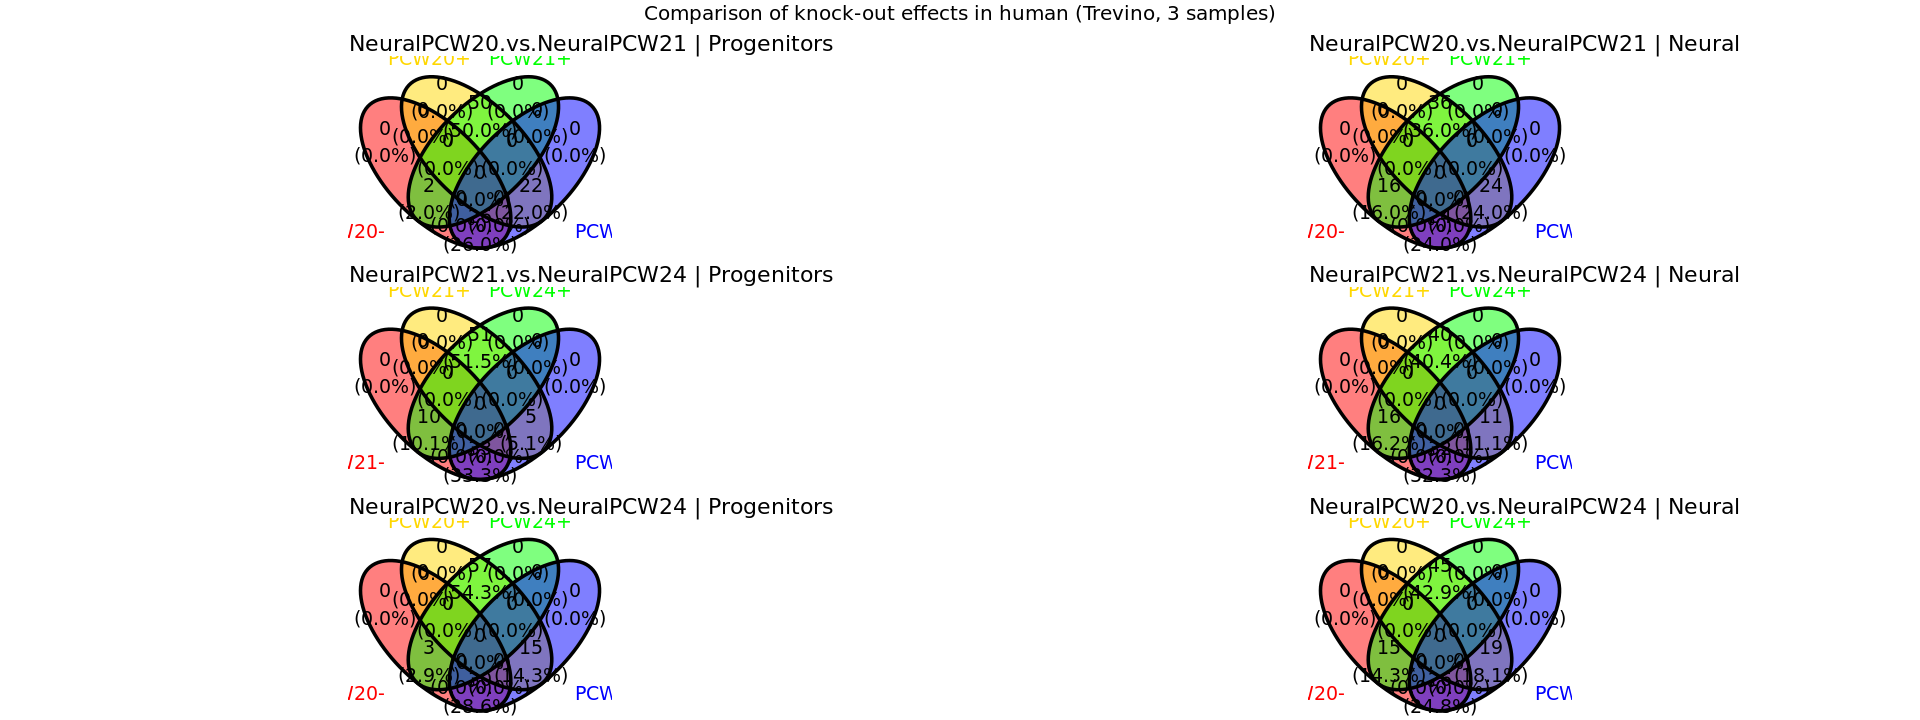

In [76]:
# Similar approach to plot Venn diagrams
venns3 <- lapply(unique(paste(comp.df$comparison, comp.df$cell.type, sep='|')), function(comct){

    # Get dataframe of cell type
    samctinfo <- strsplit(x = comct, split='|', fixed=T)[[1]] 
    samctinfo[1] -> com
    samctinfo[2] -> ct
    sams <- strsplit(x = com, split='.vs.', fixed=T)[[1]]
    sams[1] -> sam1
    sams[2] -> sam2
    
    ct.df <- subset(comp.df, (cell.type == ct) & (comparison == com)) %>% mutate(Ef_sample1 = HumanEf.sample1, Ef_sample2 = HumanEf.sample2)

    # print(ct.df)
    # Split genes
    sam1.genes <- split(ct.df$Gene, ct.df$Ef_sample1)
    names(sam1.genes) <- paste(sam1, names(sam1.genes), sep='.')
    sam2.genes <- split(ct.df$Gene, ct.df$Ef_sample2)
    names(sam2.genes) <- paste(sam2, names(sam2.genes), sep='.')

    genes.venn.list <- c(sam1.genes, sam2.genes)[c(paste(sam1, 'Down', sep='.'),
                                                     paste(sam1, 'Up', sep='.'),
                                                     paste(sam2, 'Up', sep='.'),
                                                     paste(sam2, 'Down', sep='.'))]

    # Rename for shorter
    names(genes.venn.list) %>% 
        gsub(pattern='.Down', replacement = '-', fixed=T) %>% 
        gsub(pattern='Neural', replacement = '', fixed=T) %>% 
        gsub(pattern='.Up', replacement = '+', fixed=T) -> names(genes.venn.list)

    # Plot venn
    ggvenn::ggvenn(
        set_name_color = unname(venn.colors),
        set_name_size = 4,
        genes.venn.list,
        fill_color = unname(venn.colors),
    ) + ggtitle(paste(com, '|', ct))

})


# This will plot the venn diagrams
venns_p3 <- gridExtra::grid.arrange(venns3[[2]], venns3[[1]],
                                   venns3[[4]], venns3[[3]],
                                   venns3[[6]], venns3[[5]],
                                   ncol=2, top='Comparison of knock-out effects in human (Trevino, 3 samples)')


### Plots 4: combine 2 and 3

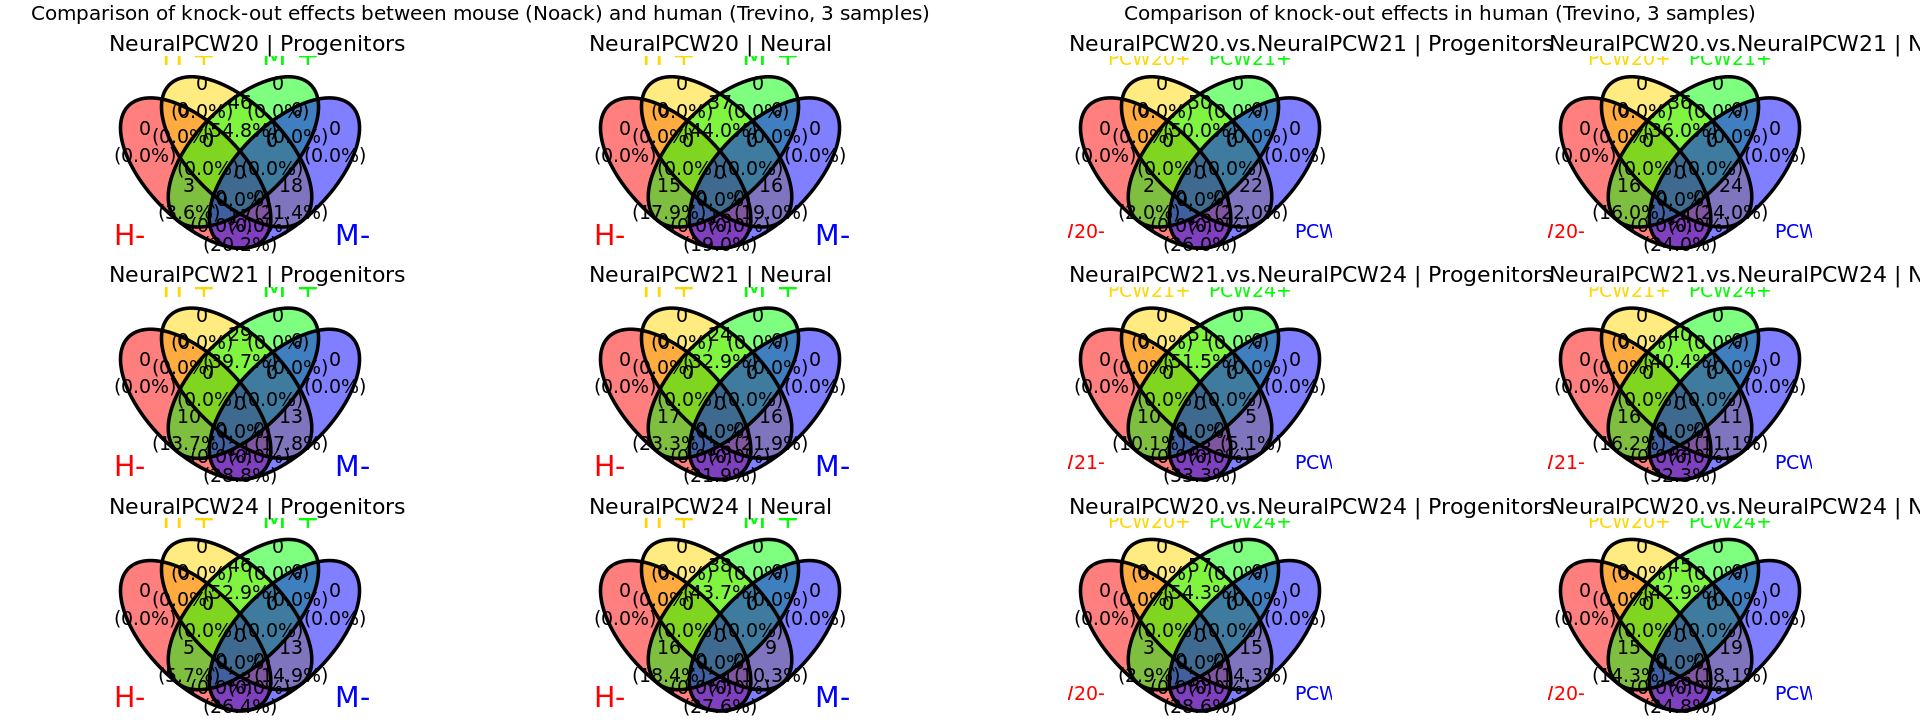

In [77]:
venns_p4 <- cowplot::plot_grid(
    venns_p2,venns_p3,
    nrow = 1)
    # align = 'h', axis = 'tb')
venns_p4


Warning message:
“Removed 398 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 518 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


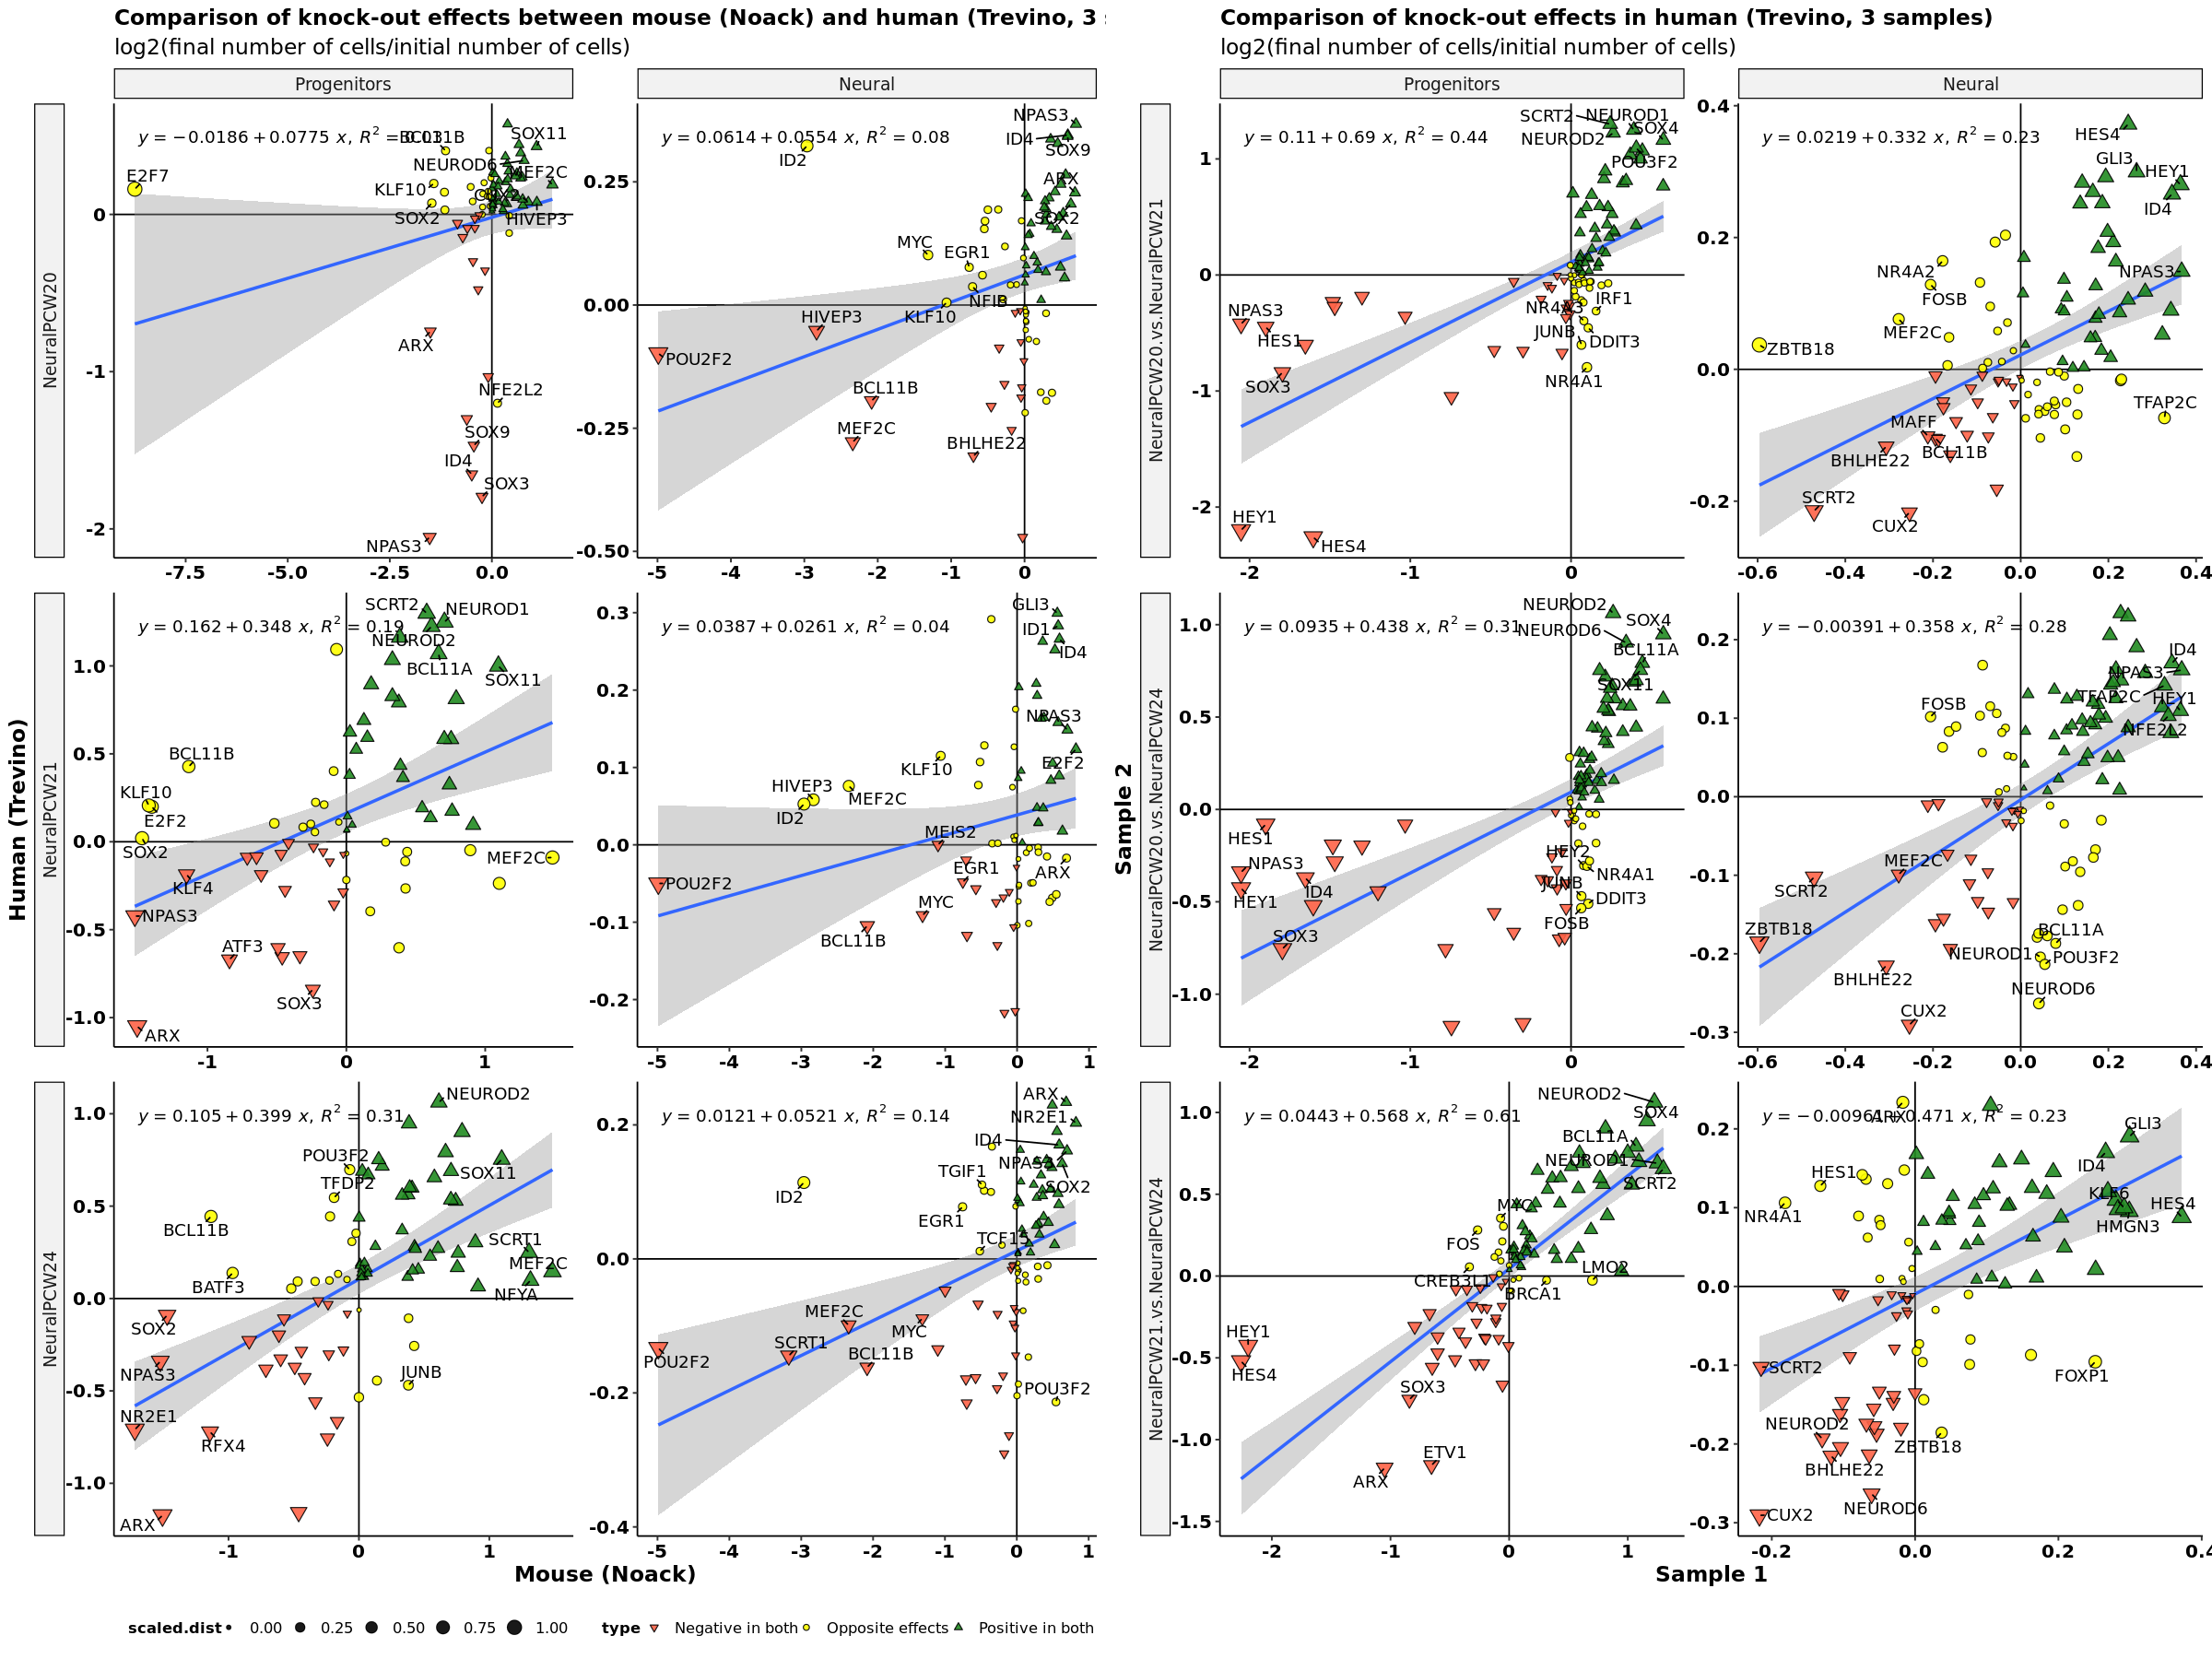

In [78]:
fig(20,15)
p4 <- cowplot::plot_grid(
    p2,p3 + theme(legend.position = "none"),
    nrow = 1, align = 'h', axis = 'tb')
p4

In [83]:
cex <- 1
pdf('Comparison_of_log2_ratios.pdf', width = 20, height = 15, useDingbats = F)
plot(p4)

plot(venns_p4)
# Plot tables of contingencies
plot.new()
gridExtra::grid.table(contingencies2,
                      theme = gridExtra::ttheme_default(
                        core = list(fg_params=list(cex = cex)),
                        colhead = list(fg_params=list(cex = cex)),
                        rowhead = list(fg_params=list(cex = cex))))
plot.new()
gridExtra::grid.table(contingencies3,
                      theme = gridExtra::ttheme_default(
                        core = list(fg_params=list(cex = cex)),
                        colhead = list(fg_params=list(cex = cex)),
                        rowhead = list(fg_params=list(cex = cex))))

dev.off()

png 
  2

### Plots

In [ ]:
library(ggpmisc)


In [ ]:
type.colors <- structure(
    c('forestgreen', 'tomato', 'yellow'), 
    names=c('Positive in both','Negative in both', 'Opposite effects'))

type.shapes <- structure(
    c('triangle filled','triangle down filled', 'circle filled'),
    names=c('Positive in both','Negative in both','Opposite effects'))

In [ ]:
venn.colors <- c(H.Down='red', H.Up='gold', M.Up='green', M.Down='blue')

In [16]:
plot_scatter_1 <- function(df, midpoint=0){
    

    p <- ggplot(df,
           aes(x=log2_ratio.Noack, y=log2_ratio.sample)) + 


        # facet_nested(cols=vars(factor(cell.type, c('Progenitors', 'nIPC', 'Neural'))),
        #              scales='free', space='fixed', independent='all') + 
        facet_wrap(ncol = 3, facets = vars(factor(cell.type, ct.factors)),
                     scales='free') + 

        geom_hline(yintercept = midpoint) + geom_vline(xintercept = midpoint) + 
        stat_poly_line() +
        stat_poly_eq(use_label(c("eq", "R2"))) +
        # stat_summary(fun.data= mean_cl_normal) + 
        # geom_smooth(method='lm') +
        # stat_cor(label.y = 30)+ #this means at 35th unit in the y axis, the r squared and p value will be shown
        # stat_regline_equation(label.y = 35) +#this means at 30th unit regresion line equation will be shown

        geom_point(aes(fill=type, #fill=scaled.prod, 
                       shape=type,
                       size=scaled.dist
                      ), 
                   alpha=0.9) +
    
        geom_text_repel(aes(label=label),
                        force = 10,
                        min.segment.length = 0,
                        max.overlaps = 10
                 ) + 
    

        ggtitle('Log2 Ratio', subtitle=sample) +
        labs(x='Mouse (Noack)', y='Human (Trevino)') +

        # scale_fill_gradient2('Effect', 
        #                      low = 'tomato', mid= 'white', high = 'forestgreen',
        #                      # breaks=c(-1,1),
        #                      # labels=c('Opposite', 'Same'),
        #                      guide=guide_colorbar(title.position = 'top')) +
        # scale_fill_viridis_c(option='magma', direction = -1) +
    
        scale_fill_manual(values=type.colors) +
        scale_shape_manual(values=type.shapes) + 
        scale_size_continuous(range=c(1,4), 
                              limits=c(0,1)
                              # guide=guide_none()
                             ) +

        scale_x_continuous(expand = expansion(mult = 0.2)) +
        scale_y_continuous(expand = expansion(mult = 0.2)) +

        theme_pubr(legend = 'left',
                   # base_family = 'ArialTM'
                   ) + 

        theme(
              # text=element_text(family = 'ArialTM')
        )
 
    return(p)
}

# Check correlation of same cell types in different subsets

In [5]:
ScoreInclude

[1] "degree_all"             "degree_centrality_all"  "degree_in"             
 [4] "degree_centrality_in"   "degree_out"             "degree_centrality_out" 
 [7] "betweenness_centrality" "eigenvector_centrality" "connectivity"          
[10] "participation"

In [6]:
pdf('CellType correlation accross subsets.pdf', width=15, height=10)

for (score in ScoreInclude){
    print(score)
    
    score.df <- NetworkScores[, c('Gene', 'cell.type', 'Sample', score)] %>% 
        reshape2::dcast(formula = 'Gene + cell.type ~ Sample', value.var=score)

    score.df <- score.df[apply(score.df, 1, function(x){sum(is.na(x))<=1}),]

    score.df[is.na(score.df)] <- 0


    p1 <- ggscatter(score.df, x = "RGCmaturation", y = "Gliogenesis", 
              add = "reg.line", conf.int = TRUE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "RGCmaturation", ylab = "Gliogenesis") +
        facet_wrap(vars(cell.type), nrow = 1, scales='free') + ggtitle(ScoreLabels[score])
    p2 <- ggscatter(score.df, x = "RGCmaturation", y = "NeuralPCW20", 
              add = "reg.line", conf.int = TRUE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "RGCmaturation", ylab = "NeuralPCW20") +
        facet_wrap(vars(cell.type), nrow = 1, scales='free') 
    p3 <- ggscatter(score.df, x = "Gliogenesis", y = "NeuralPCW20", 
              add = "reg.line", conf.int = TRUE, 
              cor.coef = TRUE, cor.method = "pearson",
              xlab = "Gliogenesis", ylab = "NeuralPCW20") +
        facet_wrap(vars(cell.type), nrow = 1, scales='free') 

    plot(cowplot::plot_grid(p1,p2,p3, ncol = 1, nrow=3))
}
dev.off()

[1] "degree_all"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "degree_centrality_all"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "degree_in"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "degree_centrality_in"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "degree_out"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "degree_centrality_out"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "betweenness_centrality"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "eigenvector_centrality"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "connectivity"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



[1] "participation"


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



png 
  2

## Genes for which we do not have scores in gliogenesis, and we have them for RGC mat

In [7]:
unique(score.df[score.df$Gliogenesis==0 & score.df$RGCmaturation != 0,]$Gene)

[1] "CEBPD"  "DDIT3"  "NFATC2" "NFIA"   "SOX11"

# Initial heatmap

## Cluster perturbation  
Important to match formula to expected axes in plots

In [8]:
cluster_genes <- function(df, score){
    
    df$Gene <- as.character(df$Gene)
    cluster.ct.df <- reshape2::dcast(
        df,
        'Gene ~ cell.type',
        value.var = score)

    cluster.ct.df <- data.frame(cluster.ct.df[,-1], row.names = cluster.ct.df[,1])
    cluster.ct.df[is.na(cluster.ct.df)] <- 0
    cluster.ct.hc <- hclust(dist(cluster.ct.df, 
                              method = 'euclidean'), 
                         method = 'ward.D2')
    cluster.ct.genes <- cluster.ct.hc[['labels']][cluster.ct.hc[['order']]]
    return(cluster.ct.genes)
}

## Heatmap score

In [9]:
library(viridis)

Loading required package: viridisLite



In [10]:
do.heatscore <- function(df, sorted_genes){

    p <- ggplot(df, aes(x=cell.type, y=factor(Gene, levels=rev(sorted_genes)), fill=plot.score)) +
      geom_tile(color='grey', linewidth=0.1) + 
      scale_fill_viridis_c(name=ScoreLabels[score], 'rocket', direction = -1) + 

      ylab('Gene') +
      xlab('Cell type') +
      ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'bottom') +
      labs_pubr(base_family = 'ArialMT') +
      guides(fill = guide_colorbar(barwidtht = 1)) +

      theme(
        panel.spacing = unit(0.2, "lines"),
        # strip.background = element_blank(),
        # strip.placement = 'outside',
        panel.background = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_text(),
        # legend.box="vertical",
        legend.text = element_text(angle=90, hjust=1, vjust=0.5))
    return(p)
}

# Option 1: Heatmap and confusions

In [11]:
library(doParallel)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [12]:
for (sample in unique(NetworkScores$Sample)){
    
    sample.df <- subset(NetworkScores, Sample == sample)
    sample.genes <- unique(sample.df$Gene)    
    
    cl <- parallel::makeForkCluster(length(ScoreInclude))
    doParallel::registerDoParallel(cl)
     
    wait_res <- foreach(score = ScoreInclude, 
                        .verbose = T ) %dopar% {
    # for (score in ScoreInclude){
    
        for (scale.score in c(FALSE)){ # we do not want scaling
            
            for (recluster in c(TRUE, FALSE)){

                for (gene.subset in c('Cores', 'Regulons', 
                                      'Disease', 'Cores+Disease',
                                      'all')){
                    
                    
                    label <- paste(sample, score, sep = '.')
                    
                    plot.df <- sample.df
                    plot.df$plot.score <- plot.df[,score, drop=T]
                    sorted_genes <- sample.genes

                    if (gene.subset=='Cores'){
                        sorted_genes <- sorted_genes[sorted_genes%in%regulon_cores]
                        plot.df <- subset(plot.df, Gene %in% regulon_cores)
                        label <- paste(label, gene.subset, sep = '.')
                        
                    } else if (gene.subset=='Regulons'){
                        sorted_genes <- sorted_genes[sorted_genes%in%regulon_genes]
                        plot.df <- subset(plot.df, Gene %in% regulon_genes)
                        label <- paste(label, gene.subset, sep = '.')
                    } else if (gene.subset=='Disease'){
                        sorted_genes <- sorted_genes[sorted_genes%in%disease_genes]
                        plot.df <- subset(plot.df, Gene %in% disease_genes)
                        label <- paste(label, gene.subset, sep = '.')
                    } else if (gene.subset=='Cores+Disease'){
                        subset.genes <- union(disease_genes, regulon_cores)
                        sorted_genes <- sorted_genes[sorted_genes%in%subset.genes]
                        plot.df <- subset(plot.df, Gene %in% subset.genes)
                        label <- paste(label, gene.subset, sep = '.')
                    } else if (gene.subset=='all'){
                        sorted_genes <- sorted_genes
                        label <- paste(label, gene.subset, sep = '.')
                    }

                    if (scale.score){
                        plot.df <- plot.df %>% group_by(Gene) %>% 
                                       mutate(plot.score=scales::rescale(x = plot.score, to = c(0,1)))
                        label <- paste(label, 'Scaled', sep = '.')
                    }

                    if (recluster){
                        sorted_genes <- cluster_genes(plot.df, score = score)
                    } else {
                        sorted_genes <- gene.peak.order[gene.peak.order%in%sorted_genes]
                        plot.df <- subset(plot.df, Gene %in% sorted_genes)
                        label <- paste(label, 'PeakSorted', sep = '.')
                    }

                    print(label)
                    n.cts <- length(unique(plot.df$cell.type))
                    n.gs <- length(unique(plot.df$Gene))
                    print(paste('# CT', n.cts, '| # genes', n.gs))

                    
                    htmp <- do.heatscore(plot.df, sorted_genes = sorted_genes)

                    pdf(file=paste0('HeatmapScore.', label, '.pdf'), 
                        width=n.cts*0.15+6, 
                        height=n.gs*0.16+3.4)#max(10, n.gs/10)) ## change this for an actual formula :) 
                    plot(htmp)
                    dev.off()



                    dis.conf.plot <- do.conf.dis.plot(genes=sorted_genes)
                    peak.conf.plot <- do.conf.peak.plot(genes=sorted_genes)

                    comb.plot <- cowplot::plot_grid(
                        htmp, 
                        peak.conf.plot + theme(axis.text.y=element_blank(),axis.title.y=element_blank()), 
                        dis.conf.plot+ theme(axis.text.y=element_blank(),axis.title.y=element_blank()),

                        nrow=1, align='h', axis='tb', 

                        rel_widths=c(1,1,1))

                    pdf(file=paste0('HeatmapScore.', label, '.Combined.pdf'), 
                        width=n.cts*0.15+9, 
                        height=n.gs*0.16+3.4)#max(10, n.gs/10)) ## change this for an actual formula :) 
                    plot(comb.plot)
                    dev.off()
                    
                }
            }
        }        
    }
    parallel::stopCluster(cl)

}

discovered package(s): 
automatically exporting the following variables from the local environment:
  cluster_genes, dis.conf.cols, DisCores, disease_genes, Diseases, DisTargets, do.conf.dis.plot, do.conf.peak.plot, do.heatscore, gene.peak.order, get.conf.dis.df, get.conf.peak.df, peak.conf.cols, PeakCores, Peaks, PeakTargets, regulon_cores, regulon_genes, sample, sample.df, sample.genes, SampleLabels, ScoreLabels 
explicitly exporting package(s): 
numValues: 10, numResults: 0, stopped: TRUE
got results for task 1
numValues: 10, numResults: 1, stopped: TRUE
returning status FALSE
got results for task 2
numValues: 10, numResults: 2, stopped: TRUE
returning status FALSE
got results for task 3
numValues: 10, numResults: 3, stopped: TRUE
returning status FALSE
got results for task 4
numValues: 10, numResults: 4, stopped: TRUE
returning status FALSE
got results for task 5
numValues: 10, numResults: 5, stopped: TRUE
returning status FALSE
got results for task 6
numValues: 10, numResults: 6, 

# Option 2: cell type comparison per disease

In [13]:
get.expand.dis.df <- function(df){
    
    dis.genes <- subset(get.conf.dis.df(unique(df$Gene)), Value!='None')
    dis.list <- split(dis.genes[,c('Gene', 'Value')], dis.genes$Disease)

    dis.df <- do.call('rbind', 
                      lapply(
                          names(dis.list),
                          function(x){

                              dgenes <- unique(dis.list[[x]]$Gene)
                              ddf <- subset(df, Gene %in% dgenes)

                              ddf$Disease <- x
                              ddf$Value <- dis.list[[x]]$Value[match(x=ddf$Gene, dis.list[[x]]$Gene)]
                              ddf

                          })) %>% mutate(Disease=factor(Disease, names(dis.list)))
    return(dis.df)
}


In [14]:
network.dis.df <- get.expand.dis.df(subset(NetworkScores, Sample %in% SampleInclude))

In [15]:
# network.dis.df$cell.type.label <- factor(CellTypeLabels[as.character(network.dis.df$cell.type)], CellTypeOrder)
network.dis.df$cell.type.label <- factor(as.character(network.dis.df$cell.type), CellTypeOrder)

In [16]:
network.dis.df$is.core <- network.dis.df$Gene %in% regulon_cores

## Boxplot

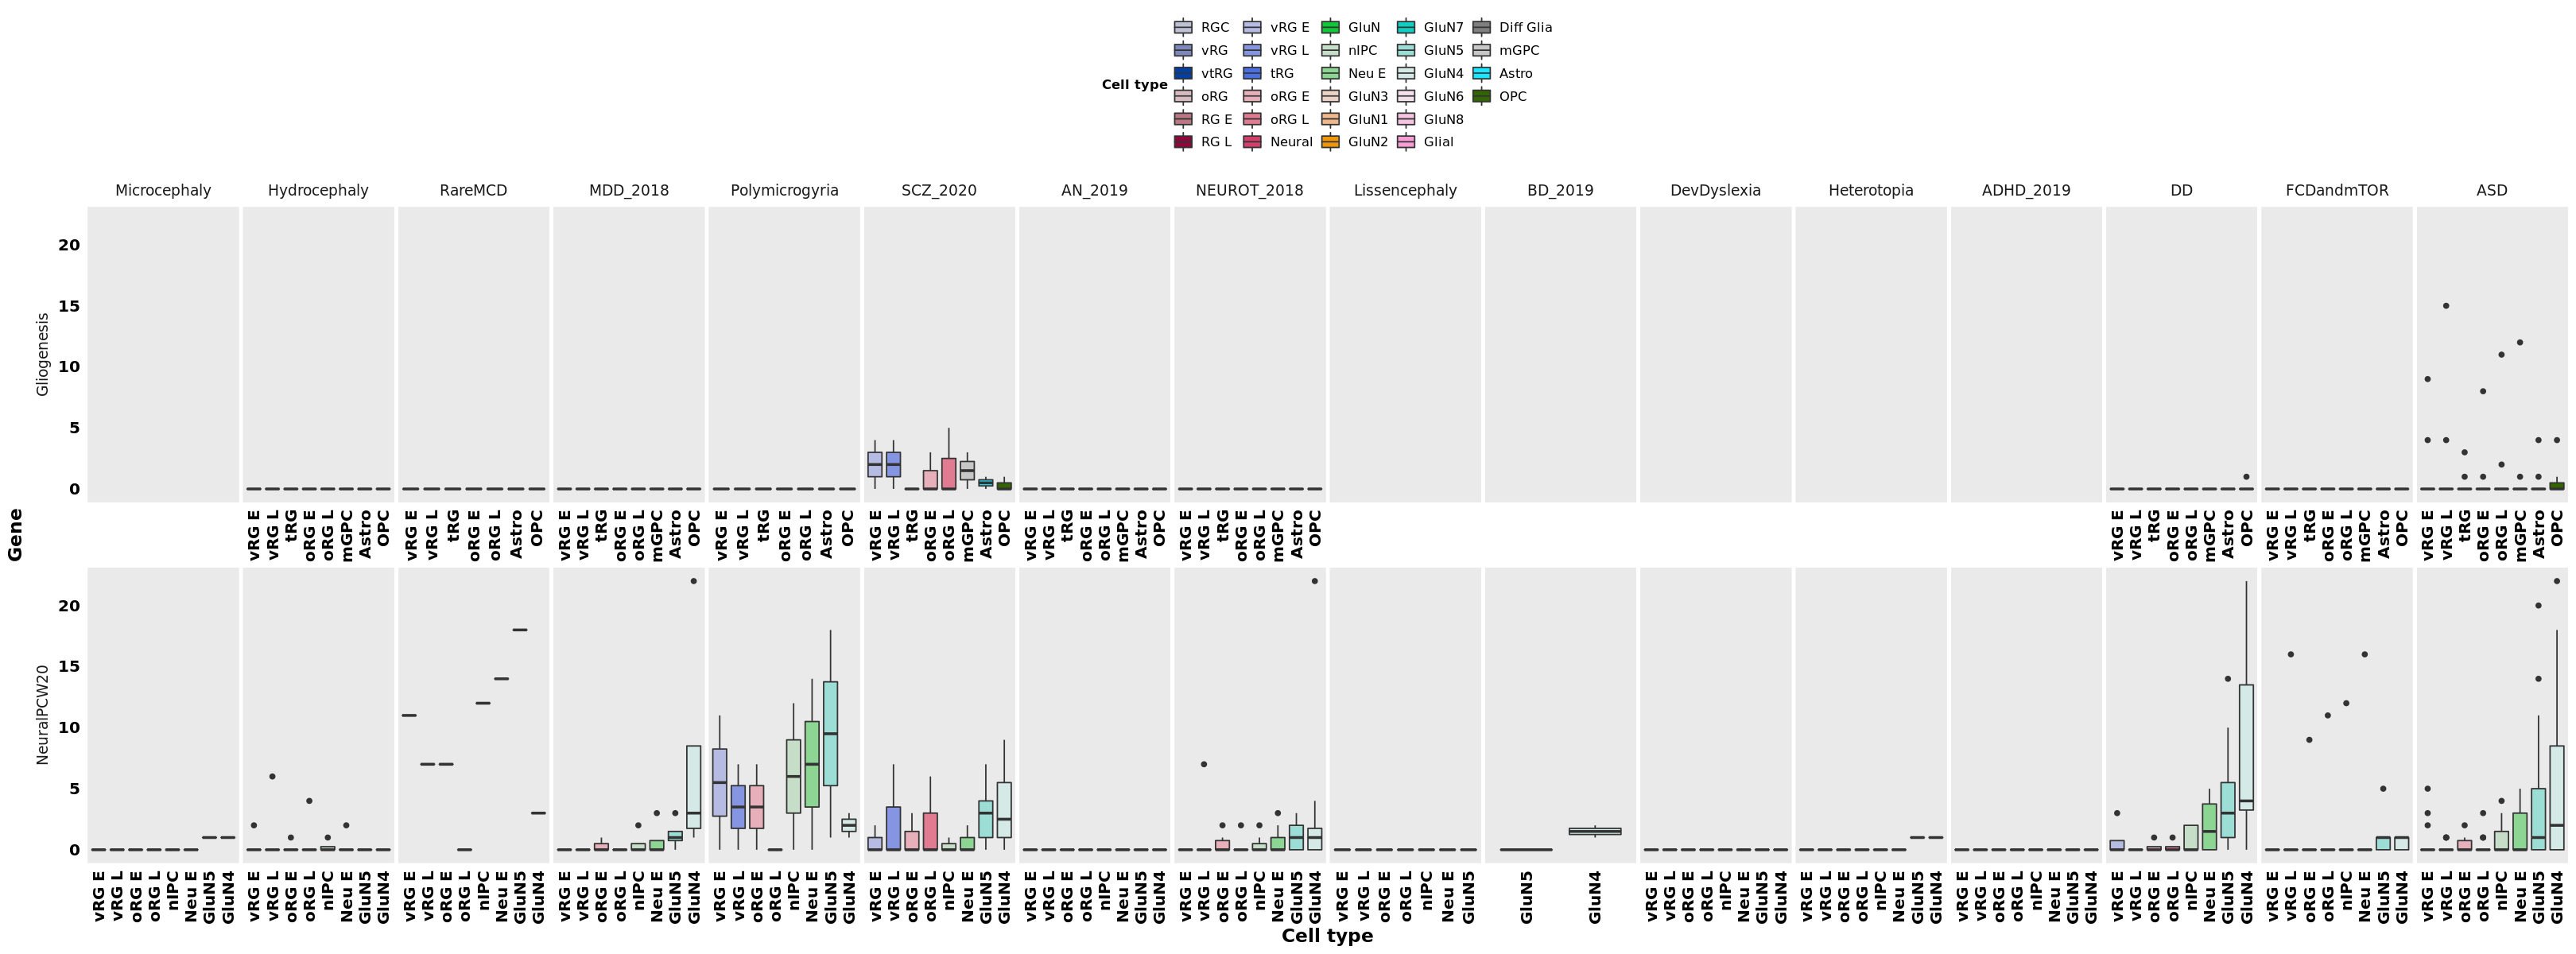

In [17]:
fig(27,10)
p <- ggplot(network.dis.df, 
            aes(x=cell.type.label, 
                y=degree_in,
                # color=Value
                fill=cell.type.label
               )) +
    facet_grid2(cols=vars(Disease), rows=vars(Sample), scales='free_x', independent = 'x', switch='y') +

    # geom_point(
    #     alpha=0.8,
    #     position=position_jitter(height=0)
    # ) + 

    geom_boxplot(
    ) + 
    scale_fill_manual('Cell type', values = CellTypeColor) +
  # scale_fill_viridis_c(name=ScoreLabels[score], 'rocket', direction = -1) + 

  ylab('Gene') +
  xlab('Cell type') +
  # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

  theme_pubr(legend = 'top') +
  labs_pubr(base_family = 'ArialMT') +
  # guides(fill = guide_colorbar(barwidtht = 1)) +

  theme(
    panel.spacing = unit(0.2, "lines"),
    strip.background = element_blank(),
    strip.placement = 'outside',
    panel.background  = element_rect(fill='#eaeaea'),element_blank(),
    axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
    axis.text.y = element_text(),
    # legend.box="vertical",
    # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
  )
p


## Violin

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two dat

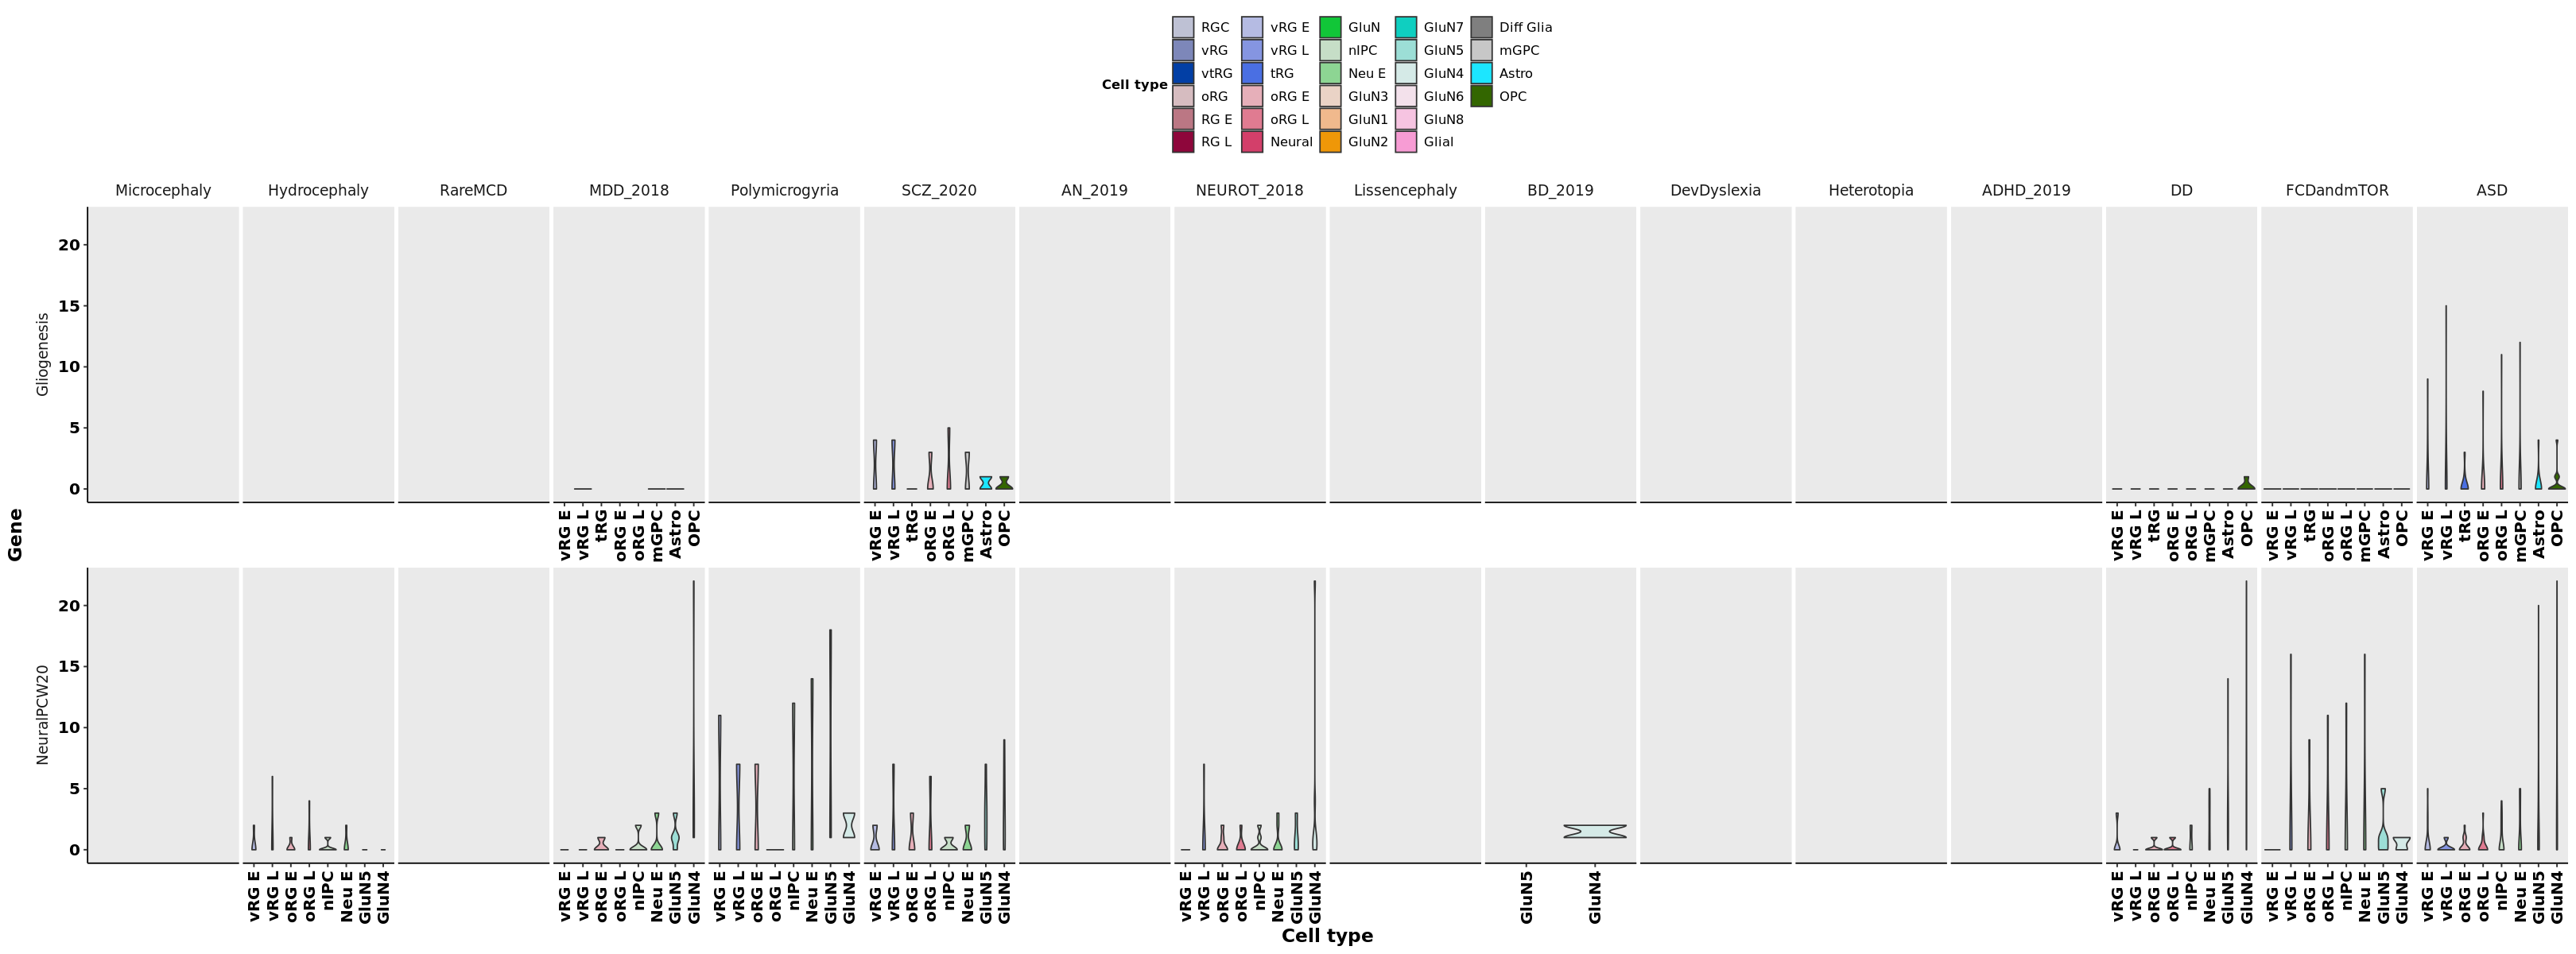

In [18]:
fig(27,10)
p <- ggplot(network.dis.df, 
            aes(x=cell.type.label, 
                y=degree_in,
                # color=Value
                fill=cell.type.label
               )) +
    facet_grid2(cols=vars(Disease), rows=vars(Sample), scales='free_x', independent = 'x', switch='y') +

    # geom_point(
    #     alpha=0.8,
    #     position=position_jitter(height=0)
    # ) + 

    geom_violin(
    ) + 
    scale_fill_manual('Cell type', values = CellTypeColor) +
  # scale_fill_viridis_c(name=ScoreLabels[score], 'rocket', direction = -1) + 

  ylab('Gene') +
  xlab('Cell type') +
  # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

  theme_pubr(legend = 'top') +
  labs_pubr(base_family = 'ArialMT') +
  # guides(fill = guide_colorbar(barwidtht = 1)) +

  theme(panel.background  = element_rect(fill='#eaeaea'),
    panel.spacing = unit(0.2, "lines"),
    strip.background = element_blank(),
    strip.placement = 'outside',
    # panel.background = element_blank(),
    axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
    axis.text.y = element_text(),
    # legend.box="vertical",
    # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
  )
p


## Manhattan Per Cell Type

In [19]:
library(ggrepel)

In [20]:
fname <- 'ScoreComparison.PerDisease.pdf'
pdf(fname, width=20, height=9, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    network.dis.df$score.plot <- network.dis.df[,score, drop=T]
    
    
    p <- ggplot(network.dis.df, 
                aes(#x=0,
                    x=cell.type.label,
                    y=score.plot,
                    # color=Value
                    color=cell.type.label
                   )) +
        facet_grid2(cols=vars(Disease), rows=vars(SampleLabel), scales='free_x', independent = 'x', switch='y') +

        geom_point(
            aes(shape=is.core),
            size=2, stroke=1,
            fill='transparent',
            alpha=0.8,
            # position=pos_jit_width
        ) + 
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) +

      ylab(ScoreLabels[score]) +
      xlab('Cell type') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'bottom') +
      labs_pubr(base_family = 'ArialMT') +
      # guides(fill = guide_colorbar(barwidtht = 1)) +

      theme(
          text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, 
                                    # linewidth=0.8,
                                    size=0.8
                                   ),
        panel.grid.major.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.grid.minor.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_text(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )



    to_annot <- network.dis.df %>% group_by(Disease, Sample) %>% 
        slice_max(order_by = score.plot, n = 5, with_ties = FALSE)
    nrow(to_annot)

    p <- p + geom_text_repel(data = to_annot,
                             mapping = aes(label=Gene), 
                         size=3, color='black',
                         # position = pos_jit_width, 
                         min.segment.length = 0)


    plot(p)
} 
dev.off()

degree_all

degree_centrality_all

degree_in

degree_centrality_in

degree_out

degree_centrality_out

betweenness_centrality

eigenvector_centrality

connectivity

participation



png 
  2

## Manhattan Per Gene

In [21]:
order_df <- function(df, grouped, label.genes = 5, only.top.n = 25){

    
    gene.maxs <- df %>% 
        group_by(Gene) %>% 
        summarise(max.score = max(score.plot), 
                  which.max.score=as.character(cell.type)[which.max(score.plot)[1]]) %>% ungroup() %>%
        arrange(desc(max.score)) %>% mutate(gene.order = order(max.score, decreasing = T, na.last = T))
    
    gene.maxs$is.top.gene <- gene.maxs$gene.order <= label.genes
    
    
    df <- merge(df, gene.maxs, by='Gene', all=T)
    df$label <- ifelse(
        (
            (as.character(df$cell.type) == df$which.max.score) &
            (df$is.top.gene)
        ),
        df$Gene, NA)
    
    
    top.genes <- unique(df$Gene[df$gene.order <= only.top.n])
    
    
    # print(df[duplicated(df$label) &  !is.na(df$label),])
        
    df <- subset(df, Gene %in% top.genes)
    return(df)
}

In [22]:
fname <- 'ScoreComparison.PerDisease.GeneView.pdf'
pdf(fname, width=20, height=9, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    
    score.df <- network.dis.df[network.dis.df[score]!=0,]
    score.df$score.plot <- score.df[,score, drop=T]
    
    
    score.df <- score.df %>%group_by(Disease, SampleLabel) %>% group_modify(.f = order_df, .keep=F) %>% ungroup()  
    
    p <- ggplot(score.df, 
                aes(#x=0,
                    # x=cell.type.label,
                    x=score.plot,
                    y=gene.order,
                    # color=Value
                    color=cell.type.label
                   ))  + 
        facet_grid2(cols=vars(Disease), rows=vars(SampleLabel), scales='free', independent = 'y', switch='y') +

        geom_point(
            aes(shape=is.core),
            size=2, stroke=1,
            fill='transparent',
            alpha=0.8,
            # position=pos_jit_width
        ) +
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) + 

      xlab(ScoreLabels[score]) +
      ylab('Gene') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'top') +
      labs_pubr(base_family = 'ArialMT') +

      scale_x_reverse(expand = expansion(mult = c(1.5,NA))) + scale_y_reverse() +
      theme(
        text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, size=0.8),
        panel.grid.major.x = element_line(color='grey', size=0.5),
        panel.grid.minor.x = element_line(color='grey', size=0.2),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_blank(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )
    
    
    p <- p + geom_text_repel(mapping = aes(label=label), 
                             max.time=10, max.iter=1E4,
                             size=3, color='black',
                             max.overlaps=10, 
                             box.padding= 0.1,
                             force = 0.1,
                             # nudge_y           = -1,
                             nudge_x           = -200,
                             direction         = "both",
                             # hjust             = 1,
                             segment.size=.5,
                             min.segment.length      = 0,
                             # segment.curvature = 0.6
                            )
    plot(p)
    # stop()
    # break
}
dev.off()

degree_all

Warning message:
“Removed 611 rows containing missing values (geom_text_repel).”
degree_centrality_all

Warning message:
“Removed 611 rows containing missing values (geom_text_repel).”
degree_in

Warning message:
“Removed 146 rows containing missing values (geom_text_repel).”
degree_centrality_in

Warning message:
“Removed 146 rows containing missing values (geom_text_repel).”
degree_out

Warning message:
“Removed 579 rows containing missing values (geom_text_repel).”
degree_centrality_out

Warning message:
“Removed 579 rows containing missing values (geom_text_repel).”
betweenness_centrality

Warning message:
“Removed 113 rows containing missing values (geom_text_repel).”
eigenvector_centrality

Warning message:
“Removed 610 rows containing missing values (geom_text_repel).”
connectivity

Warning message:
“Removed 611 rows containing missing values (geom_text_repel).”
participation

Warning message:
“Removed 507 rows containing missing values (geom_text_repel).”


png 
  2

## Unified cell types

In [23]:
network.dis.uni <- subset(network.dis.df, Sample %in% SampleInclude)
not.neu <- unique(subset(network.dis.uni, SampleLabel == 'Gliogenesis')$cell.type)
network.dis.uni <- subset(network.dis.uni, !(SampleLabel == 'Neurogenesis' & cell.type %in% not.neu))    

In [24]:
fname <- 'ScoreComparison.Unified.PerDisease.pdf'
pdf(fname, width=20, height=9, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    
    network.dis.uni$score.plot <- network.dis.uni[,score, drop=T]


    p <- ggplot(network.dis.uni, 
                aes(#x=0,
                    x=cell.type.label,
                    y=score.plot,
                    # color=Value
                    color=cell.type.label
                   )) +
        facet_wrap(vars(Disease), scales='free_x', ncol=if (tf_only) 8 else 9) +

        geom_point(
            aes(shape=is.core),
            size=2, stroke=1,
            fill='transparent',
            alpha=0.8,
            # position=pos_jit_width
        ) + 
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) +

      ylab(ScoreLabels[score]) +
      xlab('Cell type') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'bottom') +
      labs_pubr(base_family = 'ArialMT') +
      # guides(fill = guide_colorbar(barwidtht = 1)) +

      theme(
          text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, 
                                    # linewidth=0.8,
                                    size=0.8
                                   ),
        panel.grid.major.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.grid.minor.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_text(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )



    to_annot <- network.dis.uni %>% group_by(Disease) %>% 
        slice_max(order_by = score.plot, n = 10, with_ties = FALSE)
    nrow(to_annot)

    p <- p + geom_text_repel(data = to_annot,
                             mapping = aes(label=Gene), 
                         size=3, color='black',
                         # position = pos_jit_width, 
                         min.segment.length = 0)


    plot(p)
} 
dev.off()

degree_all

degree_centrality_all

degree_in

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_centrality_in

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_out

degree_centrality_out

betweenness_centrality

eigenvector_centrality

connectivity

participation

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [25]:
CellTypeColor <- setNames(
    c(
        '#bec1d4','#7d87b9','#023fa5','#d6bcc0','#bb7784','#8e063b','#b5bbe3',
        '#8595e1','#4a6fe3','#e6afb9','#e07b91','#d33f6a','#11c638','#8dd593',
        '#c6dec7','#ead3c6','#f0b98d','#ef9708','#0fcfc0','#9cded6','#d5eae7',
        '#f3e1eb','#f6c4e1','#f79cd4','#7f7f7f','#c7c7c7','#1CE6FF','#336600'
    )[1:length(CellTypeOrder)],
    CellTypeOrder)


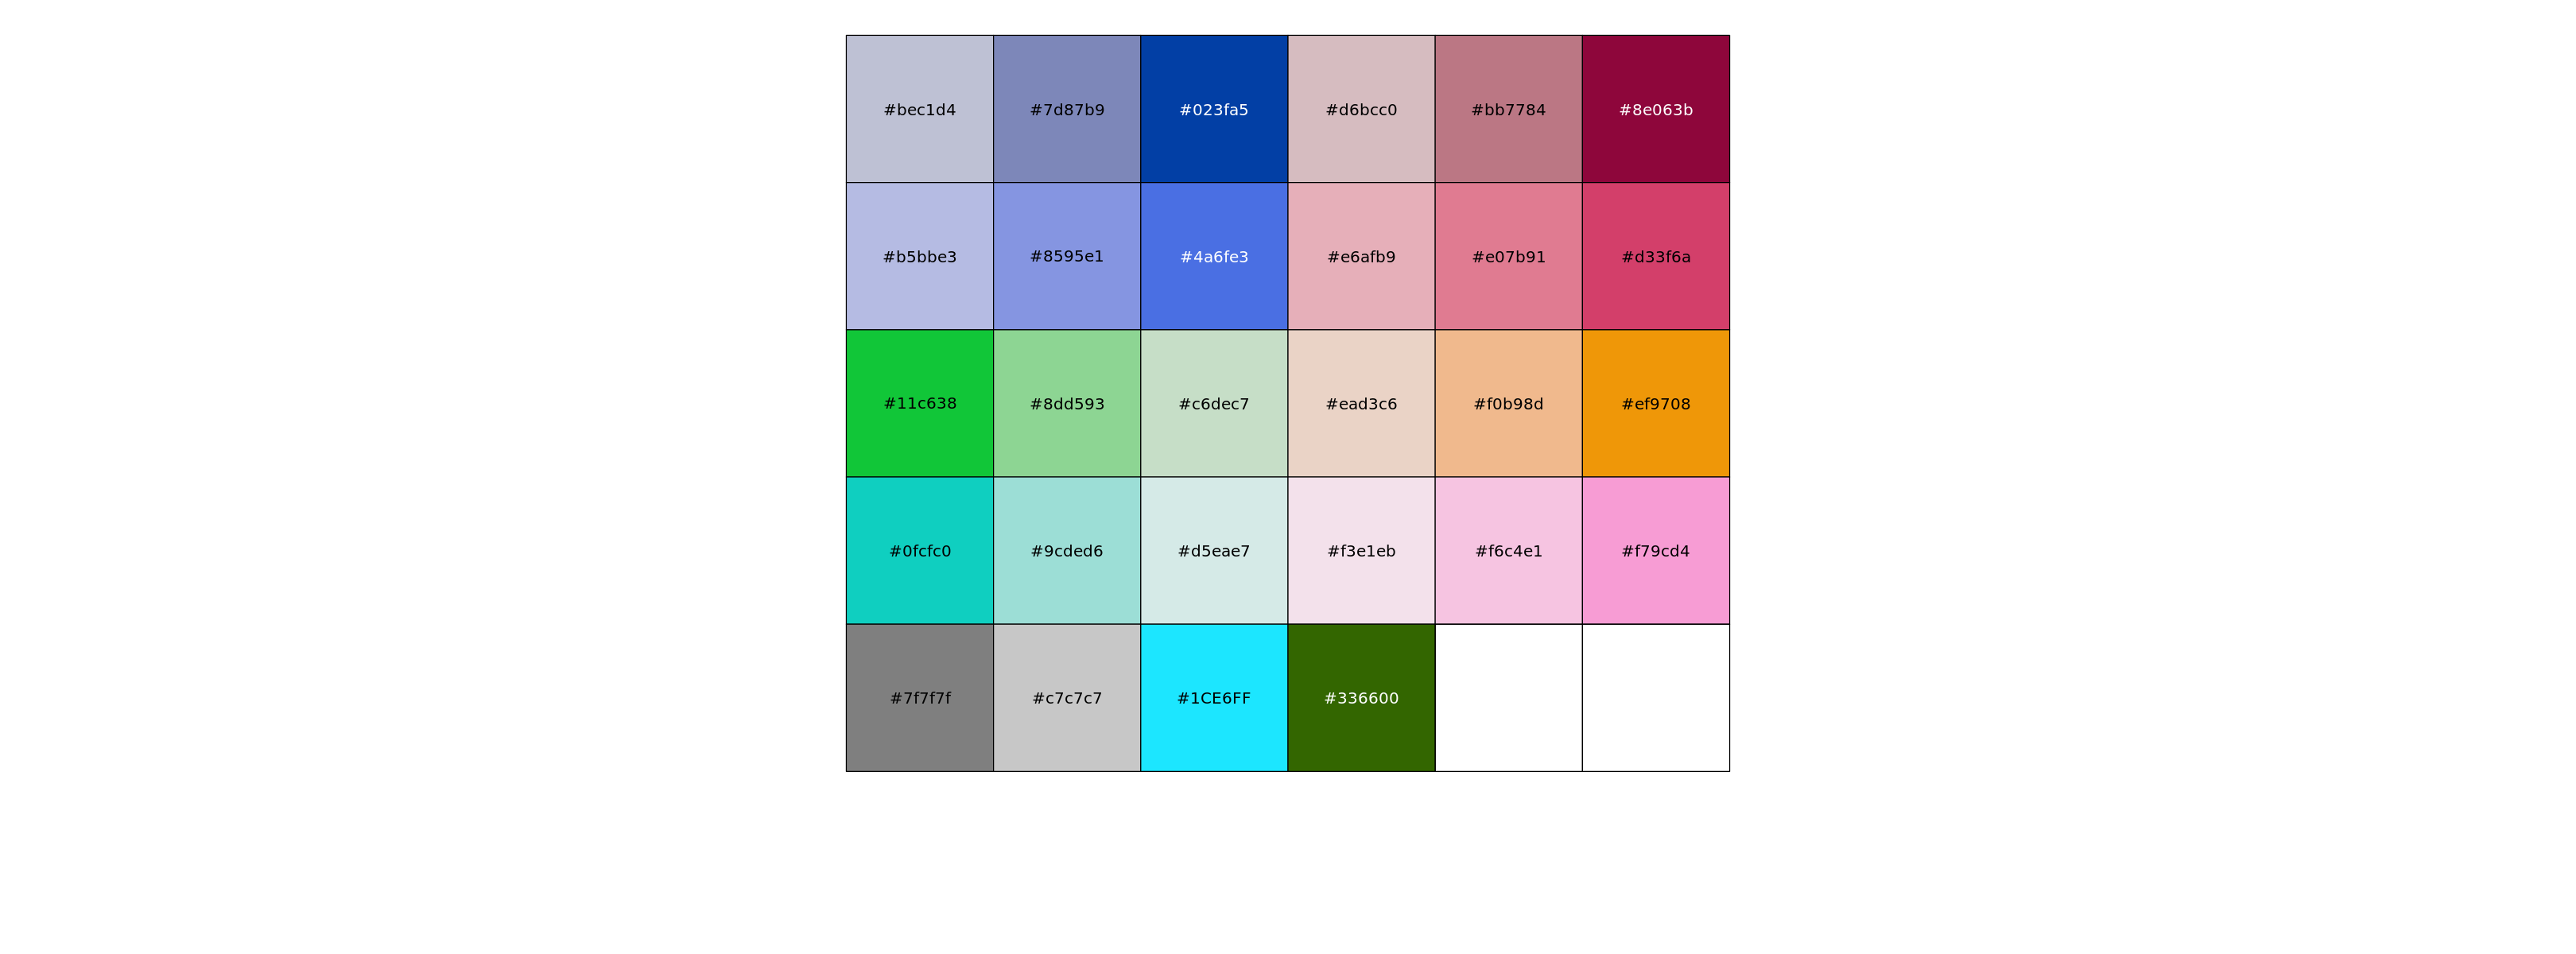

In [26]:
scales::show_col(CellTypeColor)

In [27]:
pos_jit_width <- position_jitter(width = 0.1, height=0, seed = 1)

### Top Diseases

In [28]:
fname <- 'ScoreComparison.Unified.PerDisease.Top.pdf'
pdf(fname, width=21, height=6, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    
    network.dis.uni$score.plot <- network.dis.uni[,score, drop=T]
    
    top.ten.disease <- as.character((network.dis.uni %>% group_by(Disease)%>% summarize(max=max(score.plot)) %>% arrange(desc(max)) %>% head(n=12))$Disease)
    
    p <- ggplot(subset(network.dis.uni, Disease %in% top.ten.disease), 
                aes(#x=0,
                    x=cell.type.label,
                    y=score.plot,
                    # color=Value
                    color=cell.type.label
                   )) +
        facet_wrap(vars(Disease), scales='free_x', ncol = 6) +

        geom_point(
            aes(shape=is.core),
            size=4, stroke=2,
            fill='white',
            alpha=0.9,
            position=pos_jit_width
        ) + 
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) +

      ylab(ScoreLabels[score]) +
      xlab('Cell type') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'right') +
      labs_pubr(base_family = 'ArialMT') +
      # guides(fill = guide_colorbar(barwidtht = 1)) +

      theme(
          text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, 
                                    # linewidth=0.8,
                                    size=0.8
                                   ),
        panel.grid.major.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.grid.minor.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_text(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )



    to_annot <- subset(network.dis.uni, Disease %in% top.ten.disease) %>% 
        group_by(Disease) %>% 
        slice_max(order_by = score.plot, n = 12, with_ties = FALSE)
    nrow(to_annot)

    p <- p + geom_text_repel(
        data=to_annot,
        force_pull   = 0, # do not pull toward data points
        # nudge_y      = max(to_annot$score.plot)/8,
        direction    = "y",
        # angle        = 90,
        hjust        = 0,
        # segment.size = 0.2,
        # max.iter = 1e4, max.time = 1,
        mapping = aes(label=Gene),
        size=4, color='black',
        position = pos_jit_width,
        min.segment.length = 0)

    # stop()

    plot(p)
    # break()
} 
dev.off()

degree_all

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_centrality_all

degree_in

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_centrality_in

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_out

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_centrality_out

Warning message:
“ggrepel: 1 unlabeled data point

png 
  2

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


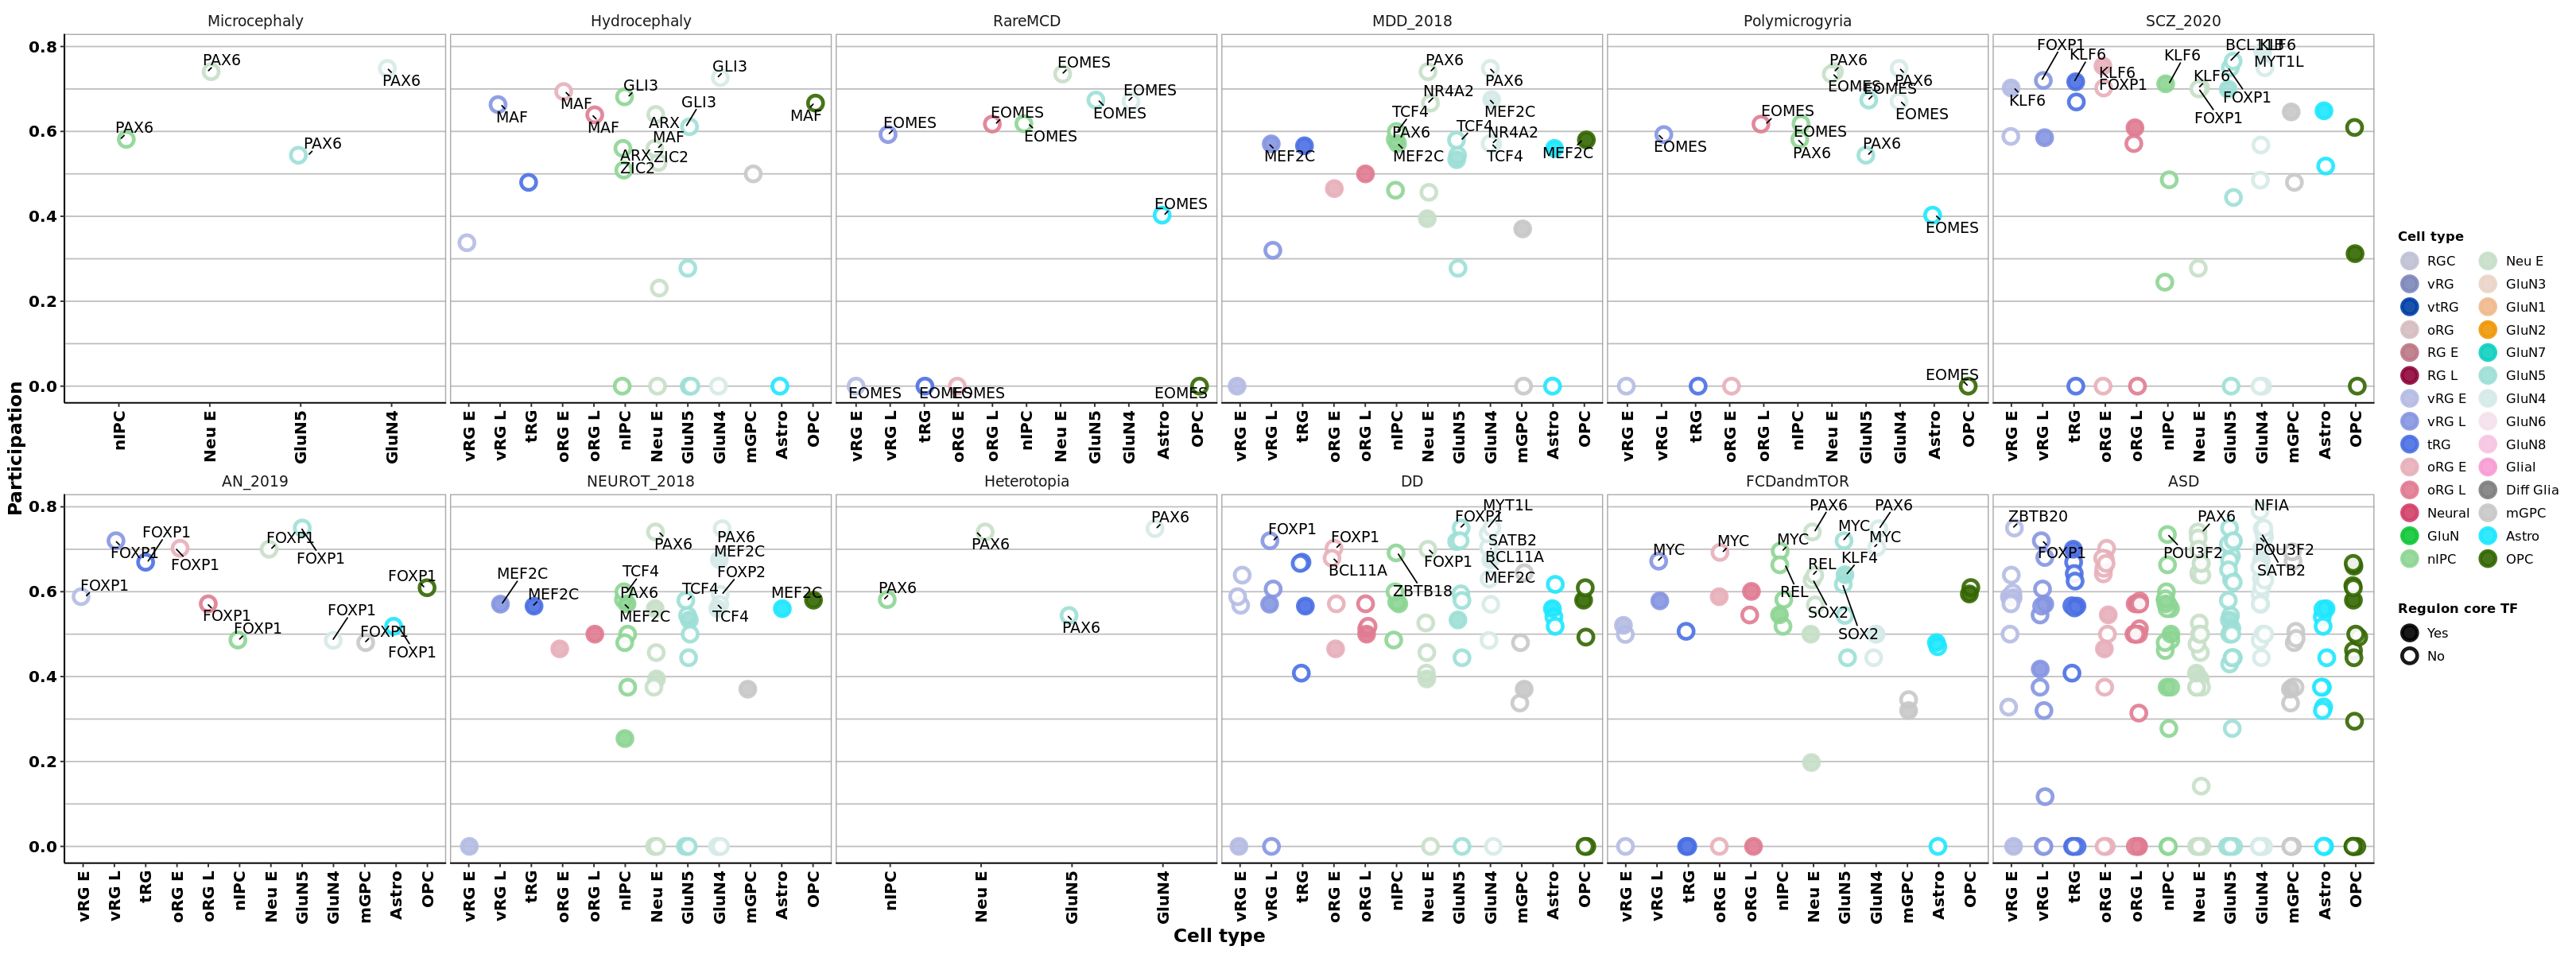

In [29]:
p

# Scatter pie test

# DotPlot with genes from neurogenesis for RGCs when Glio-scores are not available

In [30]:
library(scatterpie)

In [31]:
dp.df <- subset(NetworkScores, Sample %in% SampleInclude & Gene %in% disease_genes)

# Select only gliogenesis when neuro and glio are available
dp.df <- dp.df %>% arrange(Gene, cell.type, Sample) %>% group_by(Gene, cell.type) %>% slice_head(n=1)

# Get list of available genes
dp.genes <- as.character(unique(dp.df$Gene))
# Get list of available genes
dp.cts <- as.character(unique(sort(dp.df$cell.type)))

dp.axes.colors <- setNames(
    c('deepskyblue3', 'darkgoldenrod', 'darkolivegreen'),
    c('Neurogenesis', 'Gliogenesis', 'Neurogenesis Gliogenesis'))

# Create table of genes per sample for the plot
dp.genes.per.sample <- data.frame(
    lapply(
        lapply(
            split(dp.df$Gene, dp.df$Sample),
            unique), 
        function(x){ dp.genes%in%x }), 
    row.names=dp.genes) %>%
    
    mutate(In=paste0(
        ifelse(NeuralPCW20, 'Neurogenesis', ''),
        ifelse(NeuralPCW20 & Gliogenesis, ' ', ''),
        ifelse(Gliogenesis, 'Gliogenesis', ''))) %>% 

    mutate(Color=dp.axes.colors[In])

# Create table of cell.types per sample for the plot
dp.cts.per.sample <- data.frame(
    lapply(
        lapply(
            split(dp.df$cell.type, dp.df$Sample), 
            unique), 
        function(x){
               dp.cts%in%x
           }), 
    row.names=dp.cts) %>% 
    
    mutate(In=paste0(
        ifelse(NeuralPCW20, 'Neurogenesis', ''),
        ifelse(NeuralPCW20 & Gliogenesis, ' ', ''),
        ifelse(Gliogenesis, 'Gliogenesis', ''))) %>% 

    mutate(Color=dp.axes.colors[In])

# Gather diseases
dp.diseases <- Diseases[dp.genes,] %>% mutate_all(function(x){if (sum(x)==0) NULL else x}) %>% mutate(Gene=dp.genes)
# Append diseases
dp.df <- merge(dp.df, dp.diseases, all=T, by='Gene')

In [32]:
pdf('Dotplots.RGC_combined_genes.pdf', height=9, width=18, useDingbats = F)

## For each score
for (score in ScoreInclude){
    message(score)
    # score <- 'eigenvector_centrality'

    # Cluster scores
    score_mat <- reshape2::dcast(dp.df, formula = 'Gene ~ cell.type', value.var=score)
    score_mat[is.na(score_mat)] <- 0

    # Scale scores to see patterns in cell type trends
    score_mat[,-1] <- apply(score_mat[,-1], 2, function(x) x/max(x))
    # rowSums(score_mat[,-1])>0

    # hclust score
    dp.hc <- hclust(dist(score_mat[,-1]),method = 'ward.D2')
    dp.genes <- score_mat$Gene[dp.hc$order]

    # Get annotation of diseases
    dp.dis.df <- get.conf.dis.df(dp.genes)

    # Find and remove no risk diseases
    dis.valid <- dp.dis.df %>% group_by(Disease) %>% summarise(valid=sum(Risk) >0)
    dis.valid <- as.character(dis.valid$Disease[dis.valid$valid])
    dp.dis.colors <- DiseaseColor[dis.valid]                                                              

    dp.dis.df <- subset(dp.dis.df, Disease %in% dis.valid)
    dp.dis.df$Gene <- factor(dp.dis.df$Gene, levels = dp.genes)

                            
                            
    ## Create 3 plots: confusion and pies for diseases, dotplot for score
                            
    # 1 Plot disease confusion
    dp.dis.conf <- ggplot(dp.dis.df,
                          aes(y = factor(as.character(Disease), rev(levels(Disease))), 
                              x = Gene, 
                              fill = factor(Value, names(dis.conf.cols)))) +
        geom_tile(color = "grey", linewidth = 0.1) + 
        scale_fill_manual("Disease association", values = dis.conf.cols) + 
        theme_pubr(legend = "right") + 
        labs_pubr(base_family = "ArialMT") + 
        ylab('Disease') +
        theme(panel.spacing = unit(0.2, "lines"), 
              strip.background = element_blank(),
              panel.background = element_blank(), 
              axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
              axis.text.y = element_text())

    # 2 Plot pies
    pies.plot <- ggplot() + 
        geom_scatterpie(
            data=dp.diseases %>% mutate(x=as.numeric(factor(Gene, dp.genes))), 
            pie_scale=.5,
            aes(x=x,
                y=1),
            cols=dis.valid
        ) + coord_fixed() +
        scale_fill_manual(values=dp.dis.colors) +
        scale_x_continuous(breaks=c(1:length(dp.genes)), 
                           labels=dp.genes,
                           limits = c(0, length(dp.genes)+1),
                           expand = expansion(mult = c(0, 0))
                          ) + 

        labs(x='Gene', y='Diseases') +

        theme_pubr(legend = 'top') +
        labs_pubr(base_family = 'ArialMT') +

          theme(
              axis.line.x = element_blank(),
              axis.line.y = element_blank(),
              text = element_text(family='ArialMT'),

              panel.border = element_blank(),
              panel.grid.major.x = element_blank(),
              panel.grid.major.y = element_blank(),
              axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
              axis.text.y = element_blank(),
              axis.ticks.x = element_blank(),
              axis.ticks.y = element_blank(),
          ) 


    # 3 Dotplot
    dp.df$dp.score <- ifelse(dp.df[,score] >= 0, dp.df[,score], 0)
                            
    score.label <- ScoreLabels[score]
    if (max(dp.df$dp.score, na.rm=T)-min(dp.df$dp.score, na.rm=T) >= 1000){
        print('Log1p transforming')
        dp.df$dp.score <- log10(dp.df$dp.score+1)
        score.label <- paste0('log10(', score.label, ')')
    }
                            
    dot.plot <- ggplot(dp.df) + 

        geom_point(aes(x=factor(Gene, dp.genes), 
                       y=factor(as.character(cell.type),
                                rev(levels(cell.type))),
                       fill=dp.score,
                       size=dp.score),
                   color='black', 
                   shape=21) +
                            
        scale_size_area(name=score.label, max_size = 10, n.breaks = 10) +
        scale_fill_viridis_c(name=score.label, option='cividis') +

        labs(x='Gene', y='Cell type') +

        theme_pubr(legend = 'right') +
        labs_pubr(base_family = 'ArialMT') +

        theme(
            text = element_text(family='ArialMT'),
            panel.border = element_rect(colour = "darkgrey", fill=NA),
            panel.grid.major.x = element_line(color='grey', 
                                              size=0.5),
            panel.grid.major.y = element_line(color='grey', 
                                              size=0.5),
            axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
        )
    
    # Color axes
    # suppressWarnings(expr = {  
        
        dot.plot <- dot.plot + theme(
            axis.text.x = element_text(color=as.character(dp.genes.per.sample[dp.genes,]$Color)),
            axis.text.y = element_text(color=as.character(dp.cts.per.sample[rev(dp.cts),]$Color)),
        )
    # })

    
    # Create combined version
    dp.conf.comb <- cowplot::plot_grid(
        dp.dis.conf + theme(axis.text.x=element_blank(),
                            axis.title.x = element_blank()), 
        NULL, dot.plot + scale_size_area(name=score.label, max_size = 9, n.breaks = 10), 
        
        rel_heights = c(.4,-.09,.5),
        ncol = 1, align='vh', axis = 'lrtb')
                           
                            
    # Create combined version
    dp.pies.comb <- cowplot::plot_grid(
        pies.plot + theme(axis.text.x=element_blank(),
                          axis.title.x = element_blank(),
                          axis.title.y = element_blank()),
        NULL, dot.plot, 
        
        rel_heights = c(.4,-.12,1),
        ncol = 1, align='vh', axis = 'lrtb')
                            
    plot(dp.conf.comb)
    plot(dp.pies.comb)

}
dev.off()
    

degree_all

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degree_centrality_all

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degre

[1] "Log1p transforming"


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

eigenvector_centrality

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

connectivity

Warning message:
“Ignoring unknown parameters: linewidth”
Wa

png 
  2

# DotPlot with genes from only Gliogenesis for RGCs

In [33]:
dp.df <- subset(NetworkScores, Sample %in% SampleInclude & Gene %in% disease_genes)

# Find cts in gliogenesis and remove neurogenesis equivalents
dp.cts.not.neu <- unique(subset(dp.df, SampleLabel == 'Gliogenesis')$cell.type)
dp.df <- subset(dp.df, !(SampleLabel == 'Neurogenesis' & cell.type %in% dp.cts.not.neu))

# Get list of available genes
dp.genes <- as.character(unique(dp.df$Gene))
# Get list of available genes
dp.cts <- as.character(unique(sort(dp.df$cell.type)))


dp.axes.colors <- setNames(
    c('deepskyblue3', 'darkgoldenrod', 'darkolivegreen'),
    c('Neurogenesis', 'Gliogenesis', 'Neurogenesis Gliogenesis'))


# Create table of genes per sample for the plot
dp.genes.per.sample <- data.frame(
    lapply(
        lapply(
            split(dp.df$Gene, dp.df$Sample),
            unique), 
        function(x){ dp.genes%in%x }), 
    row.names=dp.genes) %>%

    mutate(In=paste0(
        ifelse(NeuralPCW20, 'Neurogenesis', ''),
        ifelse(NeuralPCW20 & Gliogenesis, ' ', ''),
        ifelse(Gliogenesis, 'Gliogenesis', ''))) %>% 

    mutate(Color=dp.axes.colors[In])

# Create table of cell.types per sample for the plot
dp.cts.per.sample <- data.frame(
    lapply(
        lapply(
            split(dp.df$cell.type, dp.df$Sample), 
            unique), 
        function(x){
               dp.cts%in%x
           }), 
    row.names=dp.cts) %>% 
    
    mutate(In=paste0(
        ifelse(NeuralPCW20, 'Neurogenesis', ''),
        ifelse(NeuralPCW20 & Gliogenesis, ' ', ''),
        ifelse(Gliogenesis, 'Gliogenesis', ''))) %>% 

    mutate(Color=dp.axes.colors[In])


# Gather diseases
dp.diseases <- Diseases[dp.genes,] %>% mutate_all(function(x){if (sum(x)==0) NULL else x}) %>% mutate(Gene=dp.genes)
# Append diseases
dp.df <- merge(dp.df, dp.diseases, all=T, by='Gene')

In [34]:
pdf('Dotplots.RGC_gliog_genes.pdf', height=9, width=18, useDingbats = F)

## For each score
for (score in ScoreInclude){
    message(score)
    # score <- 'eigenvector_centrality'

    # Cluster scores
    score_mat <- reshape2::dcast(dp.df, formula = 'Gene ~ cell.type', value.var=score)
    score_mat[is.na(score_mat)] <- 0

    # Scale scores to see patterns in cell type trends
    score_mat[,-1] <- apply(score_mat[,-1], 2, function(x) x/max(x))
    # rowSums(score_mat[,-1])>0

    # hclust score
    dp.hc <- hclust(dist(score_mat[,-1]),method = 'ward.D2')
    dp.genes <- score_mat$Gene[dp.hc$order]

    # Get annotation of diseases
    dp.dis.df <- get.conf.dis.df(dp.genes)

    # Find and remove no risk diseases
    dis.valid <- dp.dis.df %>% group_by(Disease) %>% summarise(valid=sum(Risk) >0)
    dis.valid <- as.character(dis.valid$Disease[dis.valid$valid])
    dp.dis.colors <- DiseaseColor[dis.valid]                                                              

    dp.dis.df <- subset(dp.dis.df, Disease %in% dis.valid)
    dp.dis.df$Gene <- factor(dp.dis.df$Gene, levels = dp.genes)

                            
                            
    ## Create 3 plots: confusion and pies for diseases, dotplot for score
                            
    # 1 Plot disease confusion
    dp.dis.conf <- ggplot(dp.dis.df,
                          aes(y = factor(as.character(Disease), rev(levels(Disease))), 
                              x = Gene, 
                              fill = factor(Value, names(dis.conf.cols)))) +
        geom_tile(color = "grey", linewidth = 0.1) + 
        scale_fill_manual("Disease association", values = dis.conf.cols) + 
        theme_pubr(legend = "right") + 
        labs_pubr(base_family = "ArialMT") + 
        ylab('Disease') +
        theme(panel.spacing = unit(0.2, "lines"), 
              strip.background = element_blank(),
              panel.background = element_blank(), 
              axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
              axis.text.y = element_text())

    # 2 Plot pies
    pies.plot <- ggplot() + 
        geom_scatterpie(
            data=dp.diseases %>% mutate(x=as.numeric(factor(Gene, dp.genes))), 
            pie_scale=.5,
            aes(x=x,
                y=1),
            cols=dis.valid
        ) + coord_fixed() +
        scale_fill_manual(values=dp.dis.colors) +
        scale_x_continuous(breaks=c(1:length(dp.genes)), 
                           labels=dp.genes,
                           limits = c(0, length(dp.genes)+1),
                           expand = expansion(mult = c(0, 0))
                          ) + 

        labs(x='Gene', y='Diseases') +

        theme_pubr(legend = 'top') +
        labs_pubr(base_family = 'ArialMT') +

          theme(
              axis.line.x = element_blank(),
              axis.line.y = element_blank(),
              text = element_text(family='ArialMT'),

              panel.border = element_blank(),
              panel.grid.major.x = element_blank(),
              panel.grid.major.y = element_blank(),
              axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
              axis.text.y = element_blank(),
              axis.ticks.x = element_blank(),
              axis.ticks.y = element_blank(),
          ) 


    # 3 Dotplot
    dp.df$dp.score <- ifelse(dp.df[,score] >= 0, dp.df[,score], 0)
    score.label <- ScoreLabels[score]
    if (max(dp.df$dp.score, na.rm=T)-min(dp.df$dp.score, na.rm=T) >= 1000){
        print('Log1p transforming')
        dp.df$dp.score <- log10(dp.df$dp.score+1)
        score.label <- paste0('log10(', score.label, ')')
    }
                            
    dot.plot <- ggplot(dp.df) + 

        geom_point(aes(x=factor(Gene, dp.genes), 
                       y=factor(as.character(cell.type),
                                rev(levels(cell.type))),
                       fill=dp.score,
                       size=dp.score),
                   color='black', 
                   shape=21) +
                            
        scale_size_area(name=score.label, max_size = 10, n.breaks = 10) +
        scale_fill_viridis_c(name=score.label, option='cividis') +

        labs(x='Gene', y='Cell type') +

        theme_pubr(legend = 'right') +
        labs_pubr(base_family = 'ArialMT') +

        theme(
            text = element_text(family='ArialMT'),
            panel.border = element_rect(colour = "darkgrey", fill=NA),
            panel.grid.major.x = element_line(color='grey', 
                                              size=0.5),
            panel.grid.major.y = element_line(color='grey', 
                                              size=0.5),
            axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
        )
    
    # Color axes
    suppressWarnings(expr = {  
        
        dot.plot <- dot.plot + theme(
            axis.text.x = element_text(color=as.character(dp.genes.per.sample[dp.genes,]$Color)),
            axis.text.y = element_text(color=as.character(dp.cts.per.sample[rev(dp.cts),]$Color)),
        )
    })

    
    # Create combined version
    dp.conf.comb <- cowplot::plot_grid(
        dp.dis.conf + theme(axis.text.x=element_blank(),
                            axis.title.x = element_blank()), 
        NULL, dot.plot + scale_size_area(name=score.label, max_size = 9, n.breaks = 10), 
        
        rel_heights = c(.4,-.09,.5),
        ncol = 1, align='vh', axis = 'lrtb')
                           
                            
    # Create combined version
    dp.pies.comb <- cowplot::plot_grid(
        pies.plot + theme(axis.text.x=element_blank(),
                          axis.title.x = element_blank(),
                          axis.title.y = element_blank()),
        NULL, dot.plot, 
        
        rel_heights = c(.4,-.12,1),
        ncol = 1, align='vh', axis = 'lrtb')
                            
    plot(dp.conf.comb)
    plot(dp.pies.comb)
}
dev.off()
    

degree_all

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degree_centrality_all

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degree_in

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degree_centrality_in

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degree_out

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

degree_centrality_out

Warning message:
“Ignoring unknown parameters: linewidth”

[1] "Log1p transforming"


Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

eigenvector_centrality

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

connectivity

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

participation

Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



png 
  2

# Option 2: cell type comparison per peak

In [35]:
meta.colors$PeakSample

P2.FGF20  P2.FGF10   P2.FGF1 P2.FGF0.1  P3.FGF20  P3.FGF10   P3.FGF1 P3.FGF0.1 
"#006D2C" "#31A354" "#74C476" "#BAE4B3" "#08519C" "#3182BD" "#6BAED6" "#BDD7E7" 
 P4.FGF20  P4.FGF10   P4.FGF1 P4.FGF0.1  P6.FGF20  P6.FGF10   P6.FGF1 P6.FGF0.1 
"#A50F15" "#DE2D26" "#FB6A4A" "#FCAE91" "#54278F" "#756BB1" "#9E9AC8" "#CBC9E2" 
 P8.FGF20  P8.FGF10   P8.FGF1 P8.FGF0.1 
"#252525" "#636363" "#969696" "#CCCCCC"

In [36]:
get.expand.peak.df <- function(df){
    
    peak.genes <- subset(get.conf.peak.df(unique(df$Gene)), Value!='None')
    peak.list <- split(peak.genes[,c('Gene', 'Value')], peak.genes$Peak)

    peak.df <- do.call('rbind', 
                      lapply(
                          names(peak.list),
                          function(x){

                              dgenes <- unique(peak.list[[x]]$Gene)
                              ddf <- subset(df, Gene %in% dgenes)

                              ddf$Peak <- x
                              ddf$Value <- peak.list[[x]]$Value[match(x=ddf$Gene, peak.list[[x]]$Gene)]
                              ddf

                          })) %>% mutate(Peak=factor(Peak, names(peak.list)))
    return(peak.df)
}


In [37]:
network.peak.df <- get.expand.peak.df(subset(NetworkScores, Sample %in% SampleInclude))

In [38]:
# network.peak.df$cell.type.label <- factor(CellTypeLabels[as.character(network.peak.df$cell.type)], CellTypeOrder)
network.peak.df$cell.type.label <- factor(as.character(network.peak.df$cell.type), CellTypeOrder)

In [39]:
network.peak.df$is.core <- network.peak.df$Gene %in% regulon_cores

In [40]:
fname <- 'ScoreComparison.PerPeak.pdf'
pdf(fname, width=20, height=9, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    network.peak.df$score.plot <- network.peak.df[,score, drop=T]
    
    
    p <- ggplot(network.peak.df, 
                aes(#x=0,
                    x=cell.type.label, 
                    y=score.plot,
                    # color=Value
                    color=cell.type
                   )) +
        facet_grid2(cols=vars(Peak), rows=vars(SampleLabel), scales='free_x', independent = 'x', switch='y') +

        geom_point(
            aes(shape=is.core),
            size=2, stroke=1,
            fill='transparent',
            alpha=0.8,
            # position=pos_jit_width
        ) + 
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) +

      ylab(ScoreLabels[score]) +
      xlab('Cell type') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'bottom') +
      labs_pubr(base_family = 'ArialMT') +
      # guides(fill = guide_colorbar(barwidtht = 1)) +

      theme(
          text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, size=0.8),
        panel.grid.major.y = element_line(color='grey', size=0.5),
        panel.grid.minor.y = element_line(color='grey', size=0.2),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_text(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )



    to_annot <- network.peak.df %>% group_by(Peak, Sample) %>% 
        slice_max(order_by = score.plot, n = 5, with_ties = FALSE)
    nrow(to_annot)

    p <- p + geom_text_repel(data = to_annot,
                             mapping = aes(label=Gene), 
                         size=3, color='black',
                         # position = pos_jit_width, 
                         min.segment.length = 0)


    plot(p)
}  
dev.off()


degree_all

degree_centrality_all

degree_in

degree_centrality_in

degree_out

degree_centrality_out

betweenness_centrality

eigenvector_centrality

connectivity

participation



png 
  2

In [41]:
fname <- 'ScoreComparison.PerPeak.GeneView.pdf'
pdf(fname, width=20, height=9, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    
    score.df <- network.peak.df[network.peak.df[score]!=0,]
    score.df$score.plot <- score.df[,score, drop=T]
    
    
    score.df <- score.df %>%group_by(Peak, SampleLabel) %>% group_modify(.f = order_df, .keep=F) %>% ungroup()  
    
    p <- ggplot(score.df, 
                aes(#x=0,
                    # x=cell.type.label,
                    x=score.plot,
                    y=gene.order,
                    # color=Value
                    color=cell.type.label
                   ))  + 
        facet_grid2(cols=vars(Peak), rows=vars(SampleLabel), scales='free', independent = 'y', switch='y') +

        geom_point(
            aes(shape=is.core),
            size=2, stroke=1,
            fill='transparent',
            alpha=0.8,
            # position=pos_jit_width
        ) +
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) + 

      xlab(ScoreLabels[score]) +
      ylab('Gene') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'top') +
      labs_pubr(base_family = 'ArialMT') +

      scale_x_reverse(expand = expansion(mult = c(1.5,NA))) + scale_y_reverse() +
      theme(
        text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, size=0.8),
        panel.grid.major.x = element_line(color='grey', size=0.5),
        panel.grid.minor.x = element_line(color='grey', size=0.2),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_blank(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )
    
    
    p <- p + geom_text_repel(mapping = aes(label=label), 
                             max.time=10, max.iter=1E4,
                             size=3, color='black',
                             max.overlaps=10, 
                             box.padding= 0.1,
                             force = 0.1,
                             # nudge_y           = -1,
                             nudge_x           = -200,
                             direction         = "both",
                             # hjust             = 1,
                             segment.size=.5,
                             min.segment.length      = 0,
                             # segment.curvature = 0.6
                            )
    plot(p)
    # stop()
    # break
}
dev.off()

degree_all

Warning message:
“Removed 1674 rows containing missing values (geom_text_repel).”
degree_centrality_all

Warning message:
“Removed 1674 rows containing missing values (geom_text_repel).”
degree_in

Warning message:
“Removed 438 rows containing missing values (geom_text_repel).”
degree_centrality_in

Warning message:
“Removed 438 rows containing missing values (geom_text_repel).”
degree_out

Warning message:
“Removed 1587 rows containing missing values (geom_text_repel).”
degree_centrality_out

Warning message:
“Removed 1587 rows containing missing values (geom_text_repel).”
betweenness_centrality

Warning message:
“Removed 345 rows containing missing values (geom_text_repel).”
eigenvector_centrality

Warning message:
“Removed 1673 rows containing missing values (geom_text_repel).”
connectivity

Warning message:
“Removed 1670 rows containing missing values (geom_text_repel).”
participation

Warning message:
“Removed 1285 rows containing missing values (geom_text_repel).”


png 
  2

## Unified cell types

In [42]:
network.peak.uni <- subset(network.peak.df, Sample %in% SampleInclude)
not.neu <- unique(subset(network.peak.uni, SampleLabel == 'Gliogenesis')$cell.type)
network.peak.uni <- subset(network.peak.uni, !(SampleLabel == 'Neurogenesis' & cell.type %in% not.neu))    

In [43]:
fname <- 'ScoreComparison.Unified.PerPeak.pdf'
pdf(fname, width=20, height=9, useDingbats = F)

for (score in ScoreInclude){
    message(score)
    
    network.peak.uni$score.plot <- network.peak.uni[,score, drop=T]


    p <- ggplot(network.peak.uni, 
                aes(#x=0,
                    x=cell.type.label,
                    y=score.plot,
                    # color=Value
                    color=cell.type.label
                   )) +
        facet_wrap(vars(Peak), scales='free_x', ncol=10) +

        geom_point(
            aes(shape=is.core),
            size=2, stroke=1,
            fill='transparent',
            alpha=0.8,
            # position=pos_jit_width
        ) + 
        scale_shape_manual('Regulon core TF', values=c('TRUE'=19, 'FALSE'=21), labels=c('TRUE'='Yes', 'FALSE'='No')) +
        scale_color_manual('Cell type', values = CellTypeColor) +

      ylab(ScoreLabels[score]) +
      xlab('Cell type') +
      # ggtitle(SampleLabels[sample], subtitle=paste(sample, ScoreLabels[score])) +

      theme_pubr(legend = 'bottom') +
      labs_pubr(base_family = 'ArialMT') +
      # guides(fill = guide_colorbar(barwidtht = 1)) +

      theme(
          text = element_text(family='ArialMT'),
        panel.border = element_rect(colour = "darkgrey", fill=NA, 
                                    # linewidth=0.8,
                                    size=0.8
                                   ),
        panel.grid.major.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.grid.minor.y = element_line(color='grey', 
                                          # linewidth=0.5
                                          size=0.5
                                         ),
        panel.spacing = unit(0.2, "lines"),
        strip.background = element_blank(),
        strip.placement = 'outside',
        panel.background  = element_rect(fill='white'),
        # axis.text.x = element_blank(),
        # axis.ticks.x = element_blank(),
        axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5),
        axis.text.y = element_text(),

        # legend.box="vertical",
        # legend.text = element_text(angle=90, hjust=1, vjust=0.5)
      )



    to_annot <- network.peak.uni %>% group_by(Peak) %>% 
        slice_max(order_by = score.plot, n = 10, with_ties = FALSE)
    nrow(to_annot)

    p <- p + geom_text_repel(data = to_annot,
                             mapping = aes(label=Gene), 
                         size=3, color='black',
                         # position = pos_jit_width, 
                         min.segment.length = 0)


    plot(p)
} 
dev.off()

degree_all

degree_centrality_all

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_in

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
degree_centrality_in

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider i

png 
  2